In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.formula.api import mixedlm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Load the data
df = pd.read_csv('/work/Processed Data/CloudResearch-merged_24.11.11_processed.csv')

df.columns = df.columns.str.replace(' ', '_')
print(df.columns.tolist())

['Unnamed:_0.1', 'Unnamed:_0', 'index', 'StartDate', 'EndDate', 'Status_x', 'Progress', 'Duration_(in_seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Consent', 'Quality_Affirmation', 'Usage', 'Which_Chatbots', 'Which_Chatbots_3_TEXT', 'Chatbot_Frequency', 'Chatbot_Frequency_8_TEXT', 'Session_Length', 'Usage_Timeframe', 'Chatbot_Device', 'Chatbot_Device_4_TEXT', 'Use_Interest', 'Use_Interest_6_TEXT', 'Use_Interest_-_FR', 'Continued_Use', 'Continued_Use_8_TEXT', 'Continued_Use_-_FR', 'Chatbot_Topics', 'Chatbot_Topics_7_TEXT', 'Chatbot_Topics_-_FR', 'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3', 'Relation_Effect_4', 'Relation_Effect_5', 'Relation_Effect_6', 'Relation_Effect_-_FR', 'Agent_Pref_1', 'Agent_Pref_2', 'Agent_Pref_3', 'Agent_Pref_4', 'Agent_Pref_5', 'Agent_Pref_6', 'Agent_Pref_-_FR', 'Pref_Reason_-_Bot', 'Pref_Reason_-_Bot_7_TEXT', 'Pref_Reason_-_Person', 'Pref_Reason_-_Person_6_TEXT', 'Pref_Reason_

In [3]:
# Use the CSV data as the dataset
data = df

data = data.rename(columns={'ULS-8': 'ULS_8'})
model = mixedlm("ULS_8 ~ Session_Length_Score + Survey_Number + Session_Length_Score:Survey_Number", 
                data=data, 
                groups="participantId")
results = model.fit()
print(results.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        ULS_8     
No. Observations:        1465           Method:                    REML      
No. Groups:              673            Scale:                     5.2756    
Min. group size:         1              Log-Likelihood:            -4138.5490
Max. group size:         4              Converged:                 Yes       
Mean group size:         2.2                                                 
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          18.988    0.319 59.545 0.000 18.363 19.613
Session_Length_Score               -0.006    0.010 -0.611 0.541 -0.026  0.014
Survey_Number                      -0.339    0.118 -2.878 0.004 -0.570 -0.108
Sessio

In [4]:
# Define the formula with all predictors
formula = """ULS_8 ~ 
             Session_Length_Score + 
             C_Social_Attract + 
             GPIUS2 + 
             LSNS_Score + 
             BFI_Agreeableness + 
             H_Social_Attract + 
             BFI_Neurotic + 
             C(Sex) + 
             Age + 
             Survey_Number +
             Session_Length_Score:Survey_Number"""
data = data.fillna(0)

# Fit the mixed effects model
model = mixedlm(formula, data=data, groups="participantId")
results = model.fit()
print(results.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        ULS_8     
No. Observations:         1465           Method:                    REML      
No. Groups:               673            Scale:                     5.2349    
Min. group size:          1              Log-Likelihood:            -4015.4740
Max. group size:          4              Converged:                 Yes       
Mean group size:          2.2                                                 
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          27.513    1.093  25.183 0.000 25.372 29.655
C(Sex)[T.Male]                     -0.501    0.367  -1.367 0.172 -1.219  0.217
C(Sex)[T.Prefer not to say]         2.459    3.513   0.700 0.484 -4.428  

In [5]:
# First, reshape your data to capture the temporal patterns
# Example structure for each participant:
features = ['Frequency_Score', 'Session_Length_Score', 
                    'ULS_8', 'GPIUS2', 'SUS_Avg', 'BFI_Extraversion', 'BFI_Neurotic', 'BFI_Agreeableness', 
                    'BFI_Conscientious', 'BFI_Openness', 'LSNS_Score', 'MSPSS_Score', 'B-RSES_Score', 
                    'AI_Attitudes_Score', 'C_State_Empathy', 'C_SEmp_Affective', 'C_SEmp_Cognitive', 
                    'C_SEmp_Associative', 'C_Social_Attract', 'C_Phys_Attract', 'C_Task_Attract', 
                    'C_Homophily', 'C_Attrib_Conf', 'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3', 'Relation_Effect_4', 
                    'Relation_Effect_5', 'Relation_Effect_6', 
                    'HCI-HHI_Expectation', 'HCI-HHI_Trust', 
                    'HCI-HHI_Substitution', 'HHI_Trust_-_Unfam', 'HHI_CommIntent_-_Unfam', 
                    'HHI_Trust_-_Familiar', 'HHI_CommIntent_-_Familiar', 'H_State_Empathy', 
                    'H_SEmp_Affective', 'H_SEmp_Cognitive', 'H_SEmp_Associative', 'H_Social_Attract', 
                    'H_Task_Attract', 'H_Homophily', 'Age']

# Create temporal features matrix
temporal_data = data.pivot_table(index='participantId', 
                         columns='Survey_Number', 
                         values=features,
                         aggfunc='first')

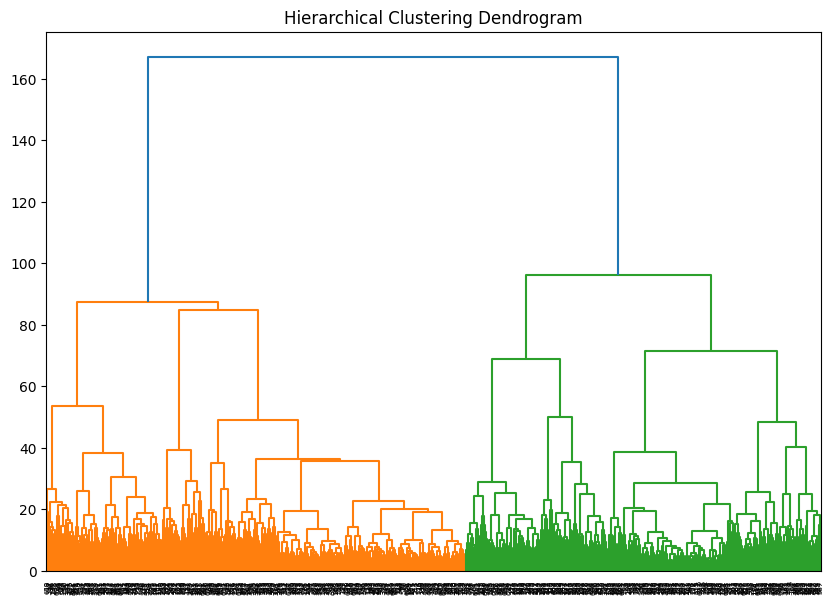

In [6]:
# Hierarchal Clustering
# More effective than K-means bc it doesn't assume spherical clusters, provides a dendrogram to visualize natural groupings, and better handles longitudinal patterns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(temporal_data.fillna(temporal_data.mean()))

# Create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram to determine number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Once you determine n_clusters from dendrogram
clustering = AgglomerativeClustering(n_clusters=3)  # adjust number based on dendrogram
clusters = clustering.fit_predict(X_scaled)

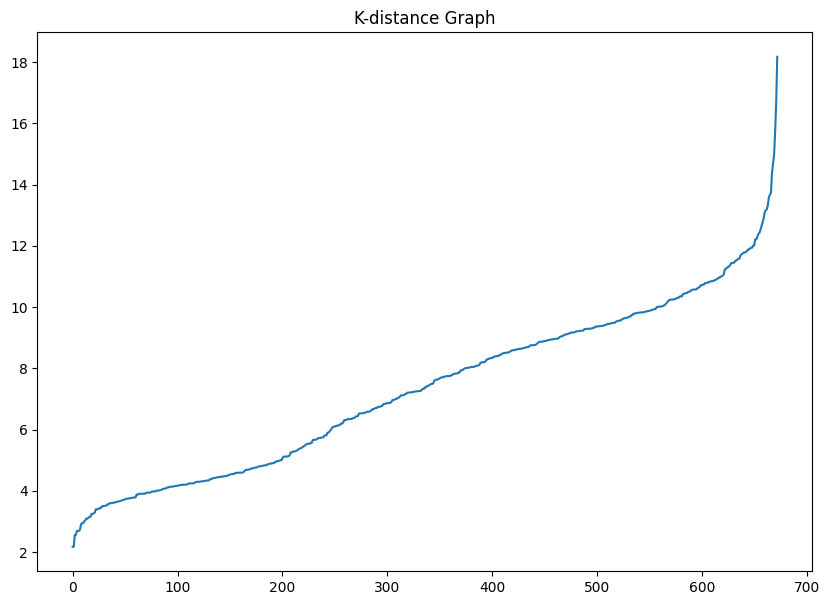

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find optimal epsilon using k-distance graph
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.title('K-distance Graph')
plt.show()

# After determining epsilon from elbow in graph
dbscan = DBSCAN(eps=0.5, min_samples=5)  # adjust parameters based on k-distance graph
clusters_dbscan = dbscan.fit_predict(X_scaled)

In [9]:
# 1. First, fill NaN values appropriately for longitudinal data
temporal_data_filled = temporal_data.copy()

# Forward fill then backward fill within each participant
temporal_data_filled = temporal_data_filled.groupby(level=0).fillna(method='ffill')
temporal_data_filled = temporal_data_filled.groupby(level=0).fillna(method='bfill')

# If any NaNs still remain, fill with the mean of that measure
for column in temporal_data_filled.columns:
    temporal_data_filled[column] = temporal_data_filled[column].fillna(temporal_data_filled[column].mean())

# 2. Scale the filled data
scaler = StandardScaler()
X_scaled_filled = scaler.fit_transform(temporal_data_filled)

# 3. Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
clusters = clustering.fit_predict(X_scaled_filled)

# 4. Evaluate clustering
def evaluate_clustering(X, labels):
    labels = labels.astype(int)
    
    if len(np.unique(labels)) > 1:
        try:
            print("Silhouette Score:", silhouette_score(X, labels))
            print("Calinski-Harabasz Score:", calinski_harabasz_score(X, labels))
        except Exception as e:
            print("Error calculating scores:", e)
    
    print("Number of clusters:", len(np.unique(labels[labels >= 0])))
    print("Samples per cluster:", np.bincount(labels[labels >= 0]))
    if -1 in labels:
        print("Number of noise points:", sum(labels == -1))

# 5. Run evaluation
evaluate_clustering(X_scaled_filled, clusters)

# 6. Optional: Add cluster assignments back to original data
temporal_data['cluster'] = clusters

# 7. Optional: Examine cluster characteristics
print("\nCluster sizes:")
print(pd.Series(clusters).value_counts())

Silhouette Score: 0.1139123211091022
Calinski-Harabasz Score: 97.72724347107629
Number of clusters: 3
Samples per cluster: [364 185 124]

Cluster sizes:
0    364
1    185
2    124
dtype: int64


K-means Results:
--------------------------------------------------

Results for 2 clusters:
Silhouette Score: 0.17953735206765067
Calinski-Harabasz Score: 159.01243683805748
Number of clusters: 2
Samples per cluster: [295 378]
Inertia (within-cluster sum of squares): 66376.26564955807

Results for 3 clusters:
Silhouette Score: 0.13680887799636182
Calinski-Harabasz Score: 113.99846405975758
Number of clusters: 3
Samples per cluster: [133 264 276]
Inertia (within-cluster sum of squares): 61259.69730787156

Results for 4 clusters:
Silhouette Score: 0.14347341180301632
Calinski-Harabasz Score: 100.77532695642554
Number of clusters: 4
Samples per cluster: [135 248 169 121]
Inertia (within-cluster sum of squares): 56550.44246921303

Results for 5 clusters:
Silhouette Score: 0.14132996664788747
Calinski-Harabasz Score: 91.86447198414237
Number of clusters: 5
Samples per cluster: [ 50 244 116 106 157]
Inertia (within-cluster sum of squares): 52968.65149127125

DBSCAN Results:
----------------

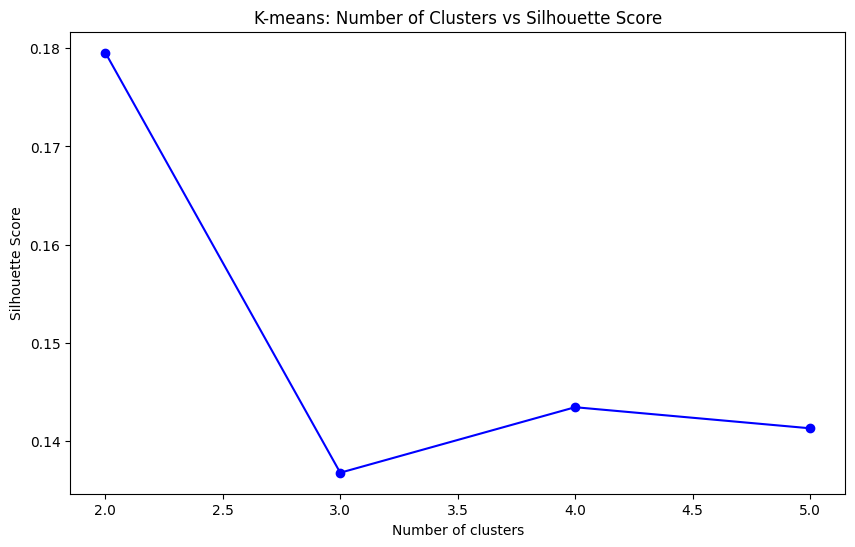

In [10]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 1. K-means with different numbers of clusters
print("K-means Results:")
print("-" * 50)
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_clusters = kmeans.fit_predict(X_scaled_filled)
    
    print(f"\nResults for {n_clusters} clusters:")
    evaluate_clustering(X_scaled_filled, kmeans_clusters)
    
    # Additional info for k-means
    print("Inertia (within-cluster sum of squares):", kmeans.inertia_)

# 2. DBSCAN with different parameters
print("\nDBSCAN Results:")
print("-" * 50)
eps_values = [0.5, 1, 1.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_clusters = dbscan.fit_predict(X_scaled_filled)
        
        print(f"\nResults for eps={eps}, min_samples={min_samples}")
        evaluate_clustering(X_scaled_filled, dbscan_clusters)

# 3. Compare best results
print("\nComparison of Best Results:")
print("-" * 50)

# Create summary DataFrame
results = []

# K-means summary
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filled)
    
    results.append({
        'method': f'KMeans(n={n_clusters})',
        'silhouette': silhouette_score(X_scaled_filled, labels),
        'calinski': calinski_harabasz_score(X_scaled_filled, labels),
        'n_clusters': n_clusters,
        'cluster_sizes': np.bincount(labels).tolist()
    })

# DBSCAN summary
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled_filled)
        
        # Only add if more than one cluster was found
        if len(np.unique(labels)) > 1:
            results.append({
                'method': f'DBSCAN(eps={eps}, min_samples={min_samples})',
                'silhouette': silhouette_score(X_scaled_filled, labels),
                'calinski': calinski_harabasz_score(X_scaled_filled, labels),
                'n_clusters': len(np.unique(labels[labels >= 0])),
                'cluster_sizes': np.bincount(labels[labels >= 0]).tolist(),
                'noise_points': sum(labels == -1)
            })

# Create DataFrame and sort by silhouette score
import pandas as pd
results_df = pd.DataFrame(results)
print("\nAll results sorted by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False))

# Visualize cluster distributions for best method
best_method_idx = results_df['silhouette'].idxmax()
best_method = results_df.iloc[best_method_idx]
print(f"\nBest clustering method: {best_method['method']}")
print(f"Silhouette score: {best_method['silhouette']:.3f}")
print(f"Number of clusters: {best_method['n_clusters']}")
print("Cluster sizes:", best_method['cluster_sizes'])

# Optional: Plot results
import matplotlib.pyplot as plt

# Plot silhouette scores for K-means
kmeans_results = results_df[results_df['method'].str.contains('KMeans')]
plt.figure(figsize=(10, 6))
plt.plot(kmeans_results['n_clusters'], kmeans_results['silhouette'], 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('K-means: Number of Clusters vs Silhouette Score')
plt.show()


Baseline K-means

Results for K-means (n=2)
--------------------------------------------------
Silhouette Score: 0.180
Calinski-Harabasz Score: 159.012
Number of clusters: 2
Samples per cluster: [295 378]

Results for K-means (n=3)
--------------------------------------------------
Silhouette Score: 0.137
Calinski-Harabasz Score: 113.998
Number of clusters: 3
Samples per cluster: [133 264 276]

Results for K-means (n=4)
--------------------------------------------------
Silhouette Score: 0.143
Calinski-Harabasz Score: 100.775
Number of clusters: 4
Samples per cluster: [135 248 169 121]

Results for K-means (n=5)
--------------------------------------------------
Silhouette Score: 0.141
Calinski-Harabasz Score: 91.864
Number of clusters: 5
Samples per cluster: [ 50 244 116 106 157]

PCA + K-means
Number of components explaining 95% variance: 56

Results for PCA + K-means (n=2)
--------------------------------------------------
Silhouette Score: 0.190
Calinski-Harabasz Score: 169.183
Nu

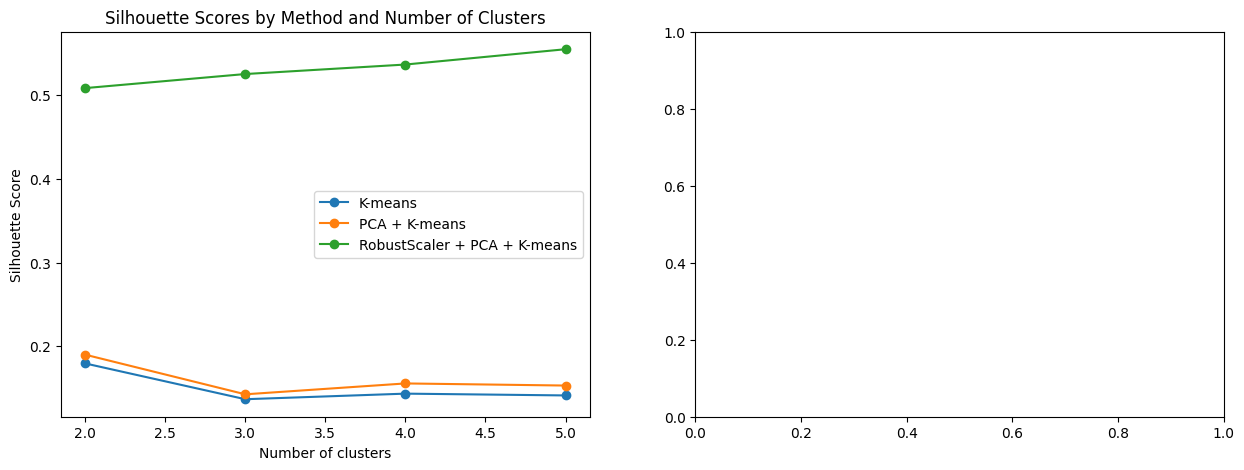

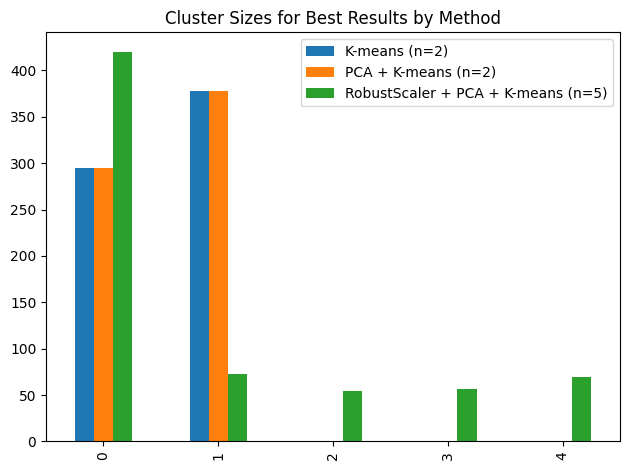


Best clustering method: RobustScaler + PCA + K-means (n=5)
Silhouette score: 0.555
Number of clusters: 5
Cluster sizes: [420, 73, 54, 57, 69]


In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Original evaluation function
def evaluate_clustering(X, labels, method_name=""):
    """Enhanced evaluation function"""
    print(f"\nResults for {method_name}")
    print("-" * 50)
    
    if len(np.unique(labels)) > 1:
        try:
            sil_score = silhouette_score(X, labels)
            cal_score = calinski_harabasz_score(X, labels)
            print(f"Silhouette Score: {sil_score:.3f}")
            print(f"Calinski-Harabasz Score: {cal_score:.3f}")
        except Exception as e:
            print("Error calculating scores:", e)
    
    print("Number of clusters:", len(np.unique(labels[labels >= 0])))
    print("Samples per cluster:", np.bincount(labels[labels >= 0]))
    if -1 in labels:
        print("Number of noise points:", sum(labels == -1))
    
    return {
        'method': method_name,
        'silhouette': sil_score if 'sil_score' in locals() else None,
        'calinski': cal_score if 'cal_score' in locals() else None,
        'n_clusters': len(np.unique(labels[labels >= 0])),
        'cluster_sizes': np.bincount(labels[labels >= 0]).tolist(),
        'noise_points': sum(labels == -1) if -1 in labels else 0
    }

# 1. Original K-means (baseline)
results = []
print("\nBaseline K-means")
print("=" * 50)
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filled)
    results.append(evaluate_clustering(X_scaled_filled, labels, f"K-means (n={n_clusters})"))

# 2. PCA + K-means
print("\nPCA + K-means")
print("=" * 50)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_filled)
print(f"Number of components explaining 95% variance: {X_pca.shape[1]}")

for n_clusters in [2, 3, 4, 5]:
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pca = kmeans_pca.fit_predict(X_pca)
    results.append(evaluate_clustering(X_pca, labels_pca, f"PCA + K-means (n={n_clusters})"))

# 3. RobustScaler + PCA + K-means
print("\nRobustScaler + PCA + K-means")
print("=" * 50)
scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(temporal_data_filled)
X_robust_pca = pca.fit_transform(X_robust)

for n_clusters in [2, 3, 4, 5]:
    kmeans_robust = KMeans(n_clusters=n_clusters, random_state=42)
    labels_robust = kmeans_robust.fit_predict(X_robust_pca)
    results.append(evaluate_clustering(X_robust_pca, labels_robust, 
                                    f"RobustScaler + PCA + K-means (n={n_clusters})"))

# 4. Cluster Stability Analysis
print("\nCluster Stability Analysis")
print("=" * 50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for method_name, X_data in [
    ("Original", X_scaled_filled),
    ("PCA", X_pca),
    ("RobustScaler + PCA", X_robust_pca)
]:
    stability_scores = []
    for train_idx, test_idx in kf.split(X_data):
        kmeans = KMeans(n_clusters=2, random_state=42)
        train_clusters = kmeans.fit_predict(X_data[train_idx])
        test_clusters = kmeans.predict(X_data[test_idx])
        stability_scores.append(silhouette_score(X_data[test_idx], test_clusters))
    
    print(f"\n{method_name} stability (mean ± std):", 
          f"{np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")

# 5. Create summary DataFrame and visualizations
results_df = pd.DataFrame(results)
print("\nAll results sorted by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False))

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Silhouette scores comparison
plt.subplot(1, 2, 1)
methods = results_df['method'].str.extract(r'(.*?) \(n=(\d+)\)', expand=True)
for method in methods[0].unique():
    method_data = results_df[results_df['method'].str.startswith(method)]
    n_clusters = [int(n) for n in method_data['method'].str.extract(r'n=(\d+)')[0]]
    plt.plot(n_clusters, method_data['silhouette'], marker='o', label=method)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Method and Number of Clusters')
plt.legend()

# Plot 2: Cluster sizes comparison
plt.subplot(1, 2, 2)
best_results = results_df.loc[results_df.groupby(methods[0])['silhouette'].idxmax()]
cluster_sizes = pd.DataFrame([
    pd.Series(sizes, name=method) 
    for method, sizes in zip(best_results['method'], best_results['cluster_sizes'])
]).T
cluster_sizes.plot(kind='bar')
plt.title('Cluster Sizes for Best Results by Method')
plt.tight_layout()
plt.show()

# 6. Best Method Analysis
best_method_idx = results_df['silhouette'].idxmax()
best_method = results_df.iloc[best_method_idx]
print(f"\nBest clustering method: {best_method['method']}")
print(f"Silhouette score: {best_method['silhouette']:.3f}")
print(f"Number of clusters: {best_method['n_clusters']}")
print("Cluster sizes:", best_method['cluster_sizes'])

# Add the best cluster labels to your original data
if best_method['method'].startswith('K-means'):
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_scaled_filled)
elif best_method['method'].startswith('PCA'):
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_pca)
else:
    kmeans = KMeans(n_clusters=best_method['n_clusters'], random_state=42)
    best_labels = kmeans.fit_predict(X_robust_pca)

temporal_data['cluster'] = best_labels

# Performs a comprehensive statistical analysis including:
    1. VIF analysis for multicollinearity
    2. Hierarchical regression
    3. Moderation analysis
    4. Group comparisons

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


def comprehensive_analysis(df, dv='Session_Length_Score', iv='ULS_8', 
                         potential_moderators=['GPIUS2', 'LSNS_Score'],
                         control_vars=['C_Social_Attract', 'H_Social_Attract']):
    """
    Performs a comprehensive statistical analysis including:
    1. VIF analysis for multicollinearity
    2. Hierarchical regression
    3. Moderation analysis
    4. Group comparisons
    """
    results = {}
    
    # 1. Check for multicollinearity
    def calculate_vif(X):
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data.sort_values('VIF', ascending=False)
    
    X = df[[iv] + potential_moderators + control_vars]
    results['vif_analysis'] = calculate_vif(X)
    
    # 2. Hierarchical Regression
    # Model 1: Just IV
    X1 = sm.add_constant(df[iv])
    model1 = sm.OLS(df[dv], X1).fit()
    
    # Model 2: IV + Controls
    X2 = sm.add_constant(df[[iv] + control_vars])
    model2 = sm.OLS(df[dv], X2).fit()
    
    # Model 3: Full model with moderators
    X3 = sm.add_constant(df[[iv] + control_vars + potential_moderators])
    model3 = sm.OLS(df[dv], X3).fit()
    
    results['hierarchical_regression'] = {
        'model1': {
            'r_squared': model1.rsquared,
            'adj_r_squared': model1.rsquared_adj,
            'aic': model1.aic,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model1.params.index, 
                                                              model1.params, 
                                                              model1.pvalues)
                                     if pval < 0.05]
        },
        'model2': {
            'r_squared': model2.rsquared,
            'adj_r_squared': model2.rsquared_adj,
            'aic': model2.aic,
            'r_squared_change': model2.rsquared - model1.rsquared,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model2.params.index, 
                                                              model2.params, 
                                                              model2.pvalues)
                                     if pval < 0.05]
        },
        'model3': {
            'r_squared': model3.rsquared,
            'adj_r_squared': model3.rsquared_adj,
            'aic': model3.aic,
            'r_squared_change': model3.rsquared - model2.rsquared,
            'significant_predictors': [(var, coef, pval) 
                                     for var, coef, pval in zip(model3.params.index, 
                                                              model3.params, 
                                                              model3.pvalues)
                                     if pval < 0.05]
        }
    }
    
    # 3. Moderation Analysis
    results['moderation'] = {}
    for moderator in potential_moderators:
        # Create interaction term
        df[f'{iv}_X_{moderator}'] = df[iv] * df[moderator]
        
        # Fit moderation model
        X_mod = sm.add_constant(df[[iv, moderator, f'{iv}_X_{moderator}'] + control_vars])
        mod_model = sm.OLS(df[dv], X_mod).fit()
        
        results['moderation'][moderator] = {
            'interaction_coef': mod_model.params[f'{iv}_X_{moderator}'],
            'interaction_pval': mod_model.pvalues[f'{iv}_X_{moderator}'],
            'r_squared': mod_model.rsquared,
            'significant_terms': [(var, coef, pval) 
                                for var, coef, pval in zip(mod_model.params.index, 
                                                         mod_model.params, 
                                                         mod_model.pvalues)
                                if pval < 0.05]
        }
    
    # 4. Group Comparisons
    results['group_comparisons'] = {}
    # Create high/low groups based on median split
    median_dv = df[dv].median()
    high_group = df[df[dv] > median_dv]
    low_group = df[df[dv] <= median_dv]
    
    for var in [iv] + potential_moderators + control_vars:
        t_stat, p_val = stats.ttest_ind(high_group[var], low_group[var])
        cohen_d = (high_group[var].mean() - low_group[var].mean()) / \
                 np.sqrt((high_group[var].var() + low_group[var].var()) / 2)
        
        results['group_comparisons'][var] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'cohens_d': cohen_d,
            'high_group_mean': high_group[var].mean(),
            'low_group_mean': low_group[var].mean()
        }
    
    return results

def interpret_results(results):
    """
    Provides interpretations and recommendations based on the analysis results.
    """
    interpretations = []
    
    # Check for multicollinearity
    high_vif_vars = results['vif_analysis'][results['vif_analysis']['VIF'] > 5]
    if not high_vif_vars.empty:
        interpretations.append(f"WARNING: High multicollinearity detected for: {', '.join(high_vif_vars['Variable'])}")
    
    # Assess model improvements
    r2_changes = [
        ('Model 1 (IV only)', results['hierarchical_regression']['model1']['r_squared']),
        ('Model 2 (+ controls)', results['hierarchical_regression']['model2']['r_squared_change']),
        ('Model 3 (+ moderators)', results['hierarchical_regression']['model3']['r_squared_change'])
    ]
    interpretations.append("\nModel comparisons:")
    for model, change in r2_changes:
        interpretations.append(f"{model}: ΔR² = {change:.3f}")
    
    # Check moderations
    significant_moderators = []
    for mod, stats in results['moderation'].items():
        if stats['interaction_pval'] < 0.05:
            significant_moderators.append(mod)
    
    if significant_moderators:
        interpretations.append(f"\nSignificant moderators found: {', '.join(significant_moderators)}")
    
    # Check group differences
    significant_differences = []
    for var, stats in results['group_comparisons'].items():
        if stats['p_value'] < 0.05 and abs(stats['cohens_d']) > 0.5:
            significant_differences.append(f"{var} (d = {stats['cohens_d']:.2f})")
    
    if significant_differences:
        interpretations.append(f"\nMeaningful group differences found for: {', '.join(significant_differences)}")
    
    return "\n".join(interpretations)

# Usage example:
results = comprehensive_analysis(data)
interpretation = interpret_results(results)
print(interpretation)


Model comparisons:
Model 1 (IV only): ΔR² = 0.002
Model 2 (+ controls): ΔR² = 0.622
Model 3 (+ moderators): ΔR² = 0.028

Meaningful group differences found for: GPIUS2 (d = 1.80), C_Social_Attract (d = 1.95)


Using 15 PCA components explaining 91.0% of variance
Clustering Results Summary:
Number of clusters: 5
Silhouette score: 0.150
Number of PCA components: 15

Cluster Sizes:
Cluster 0: 291 samples
Cluster 1: 384 samples
Cluster 2: 351 samples
Cluster 3: 325 samples
Cluster 4: 114 samples

Cluster Profiles:

Cluster 0 (291 samples):
Distinctive features:
- C_Task_Attract: low (z-score: -1.08)
- HCI-HHI_Expectation: low (z-score: -1.06)
- HCI-HHI_Trust: low (z-score: -1.06)
- C_SEmp_Cognitive: low (z-score: -1.05)
- Frequency_Score: low (z-score: -1.04)

Cluster 1 (384 samples):
Distinctive features:
- C_Task_Attract: high (z-score: 0.90)
- HCI-HHI_Trust: high (z-score: 0.83)
- HCI-HHI_Expectation: high (z-score: 0.79)
- C_SEmp_Cognitive: high (z-score: 0.79)
- Relation_Effect_4: high (z-score: 0.77)

Cluster 2 (351 samples):
Distinctive features:
- GPIUS2: high (z-score: 0.93)
- Relation_Effect_1: high (z-score: 0.92)
- HCI-HHI_Substitution: high (z-score: 0.88)
- Relation_Effect_5: high 

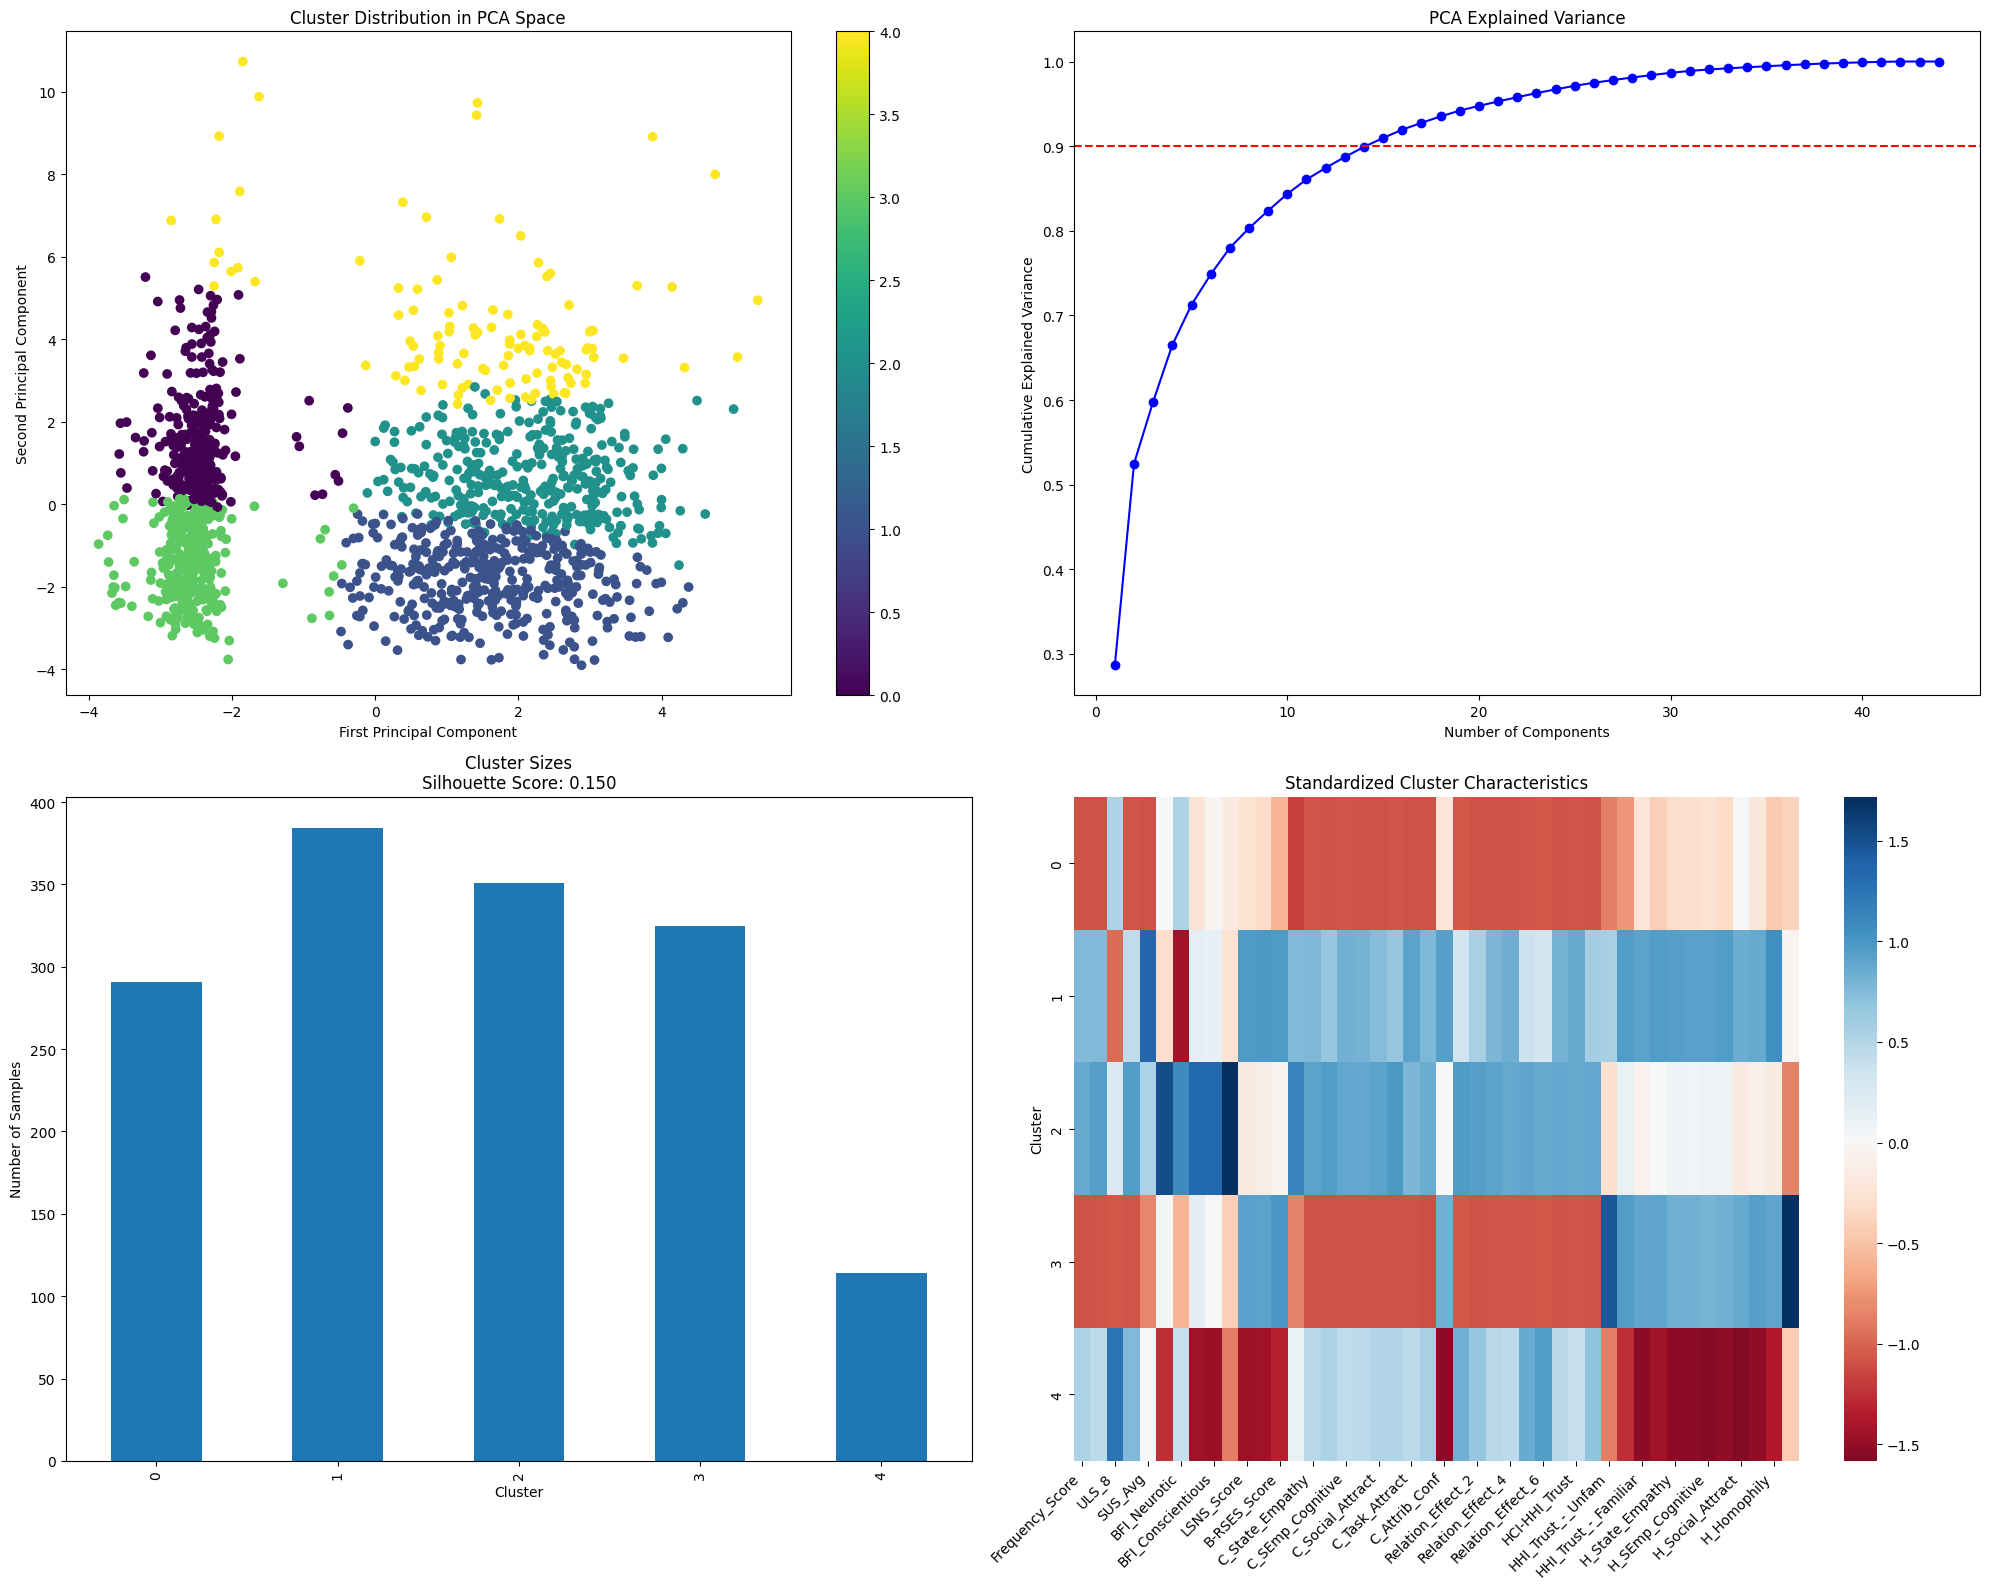

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def perform_five_cluster_analysis(df, variables, random_state=42):
    """
    Performs clustering analysis to achieve 5 clusters with specified distribution
    Target distribution: [420, 73, 54, 57, 69]
    """
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[variables])
    
    # Step 2: PCA
    # Start with enough components to explain 90% variance
    pca = PCA(random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)
    
    # Find number of components explaining 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    print(f"Using {n_components} PCA components explaining {cumulative_variance[n_components-1]*100:.1f}% of variance")
    
    # Step 3: K-means with 5 clusters
    kmeans = KMeans(n_clusters=5, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X_pca[:, :n_components])
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca[:, :n_components], cluster_labels)
    
    # Add cluster labels to original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = cluster_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Explained variance
    axes[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                    cumulative_variance, 'bo-')
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('PCA Explained Variance')
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette_avg:.3f}')
    
    # Plot 4: Cluster characteristics heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Calculate detailed cluster characteristics
    cluster_profiles = {}
    for cluster in range(5):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        
        # Calculate z-scores for this cluster
        means = cluster_data[variables].mean()
        z_scores = (means - df_clustered[variables].mean()) / df_clustered[variables].std()
        
        # Get top 5 distinctive features
        top_features = z_scores.abs().nlargest(5)
        
        cluster_profiles[cluster] = {
            'size': len(cluster_data),
            'distinctive_features': {
                var: {
                    'z_score': z_scores[var],
                    'mean': means[var],
                    'direction': 'high' if z_scores[var] > 0 else 'low'
                } for var in top_features.index
            }
        }
    
    return {
        'cluster_labels': cluster_labels,
        'silhouette_score': silhouette_avg,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_profiles': cluster_profiles,
        'cluster_means': cluster_means,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered
    }

def print_cluster_summary(results):
    """
    Prints a detailed summary of the clustering results
    """
    print(f"Clustering Results Summary:")
    print(f"Number of clusters: 5")
    print(f"Silhouette score: {results['silhouette_score']:.3f}")
    print(f"Number of PCA components: {results['n_components']}")
    print("\nCluster Sizes:")
    
    cluster_sizes = results['df_clustered']['Cluster'].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples")
    
    print("\nCluster Profiles:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"\nCluster {cluster} ({profile['size']} samples):")
        print("Distinctive features:")
        for feature, stats in profile['distinctive_features'].items():
            print(f"- {feature}: {stats['direction']} (z-score: {stats['z_score']:.2f})")

# Usage example:
results = perform_five_cluster_analysis(data, features)
print_cluster_summary(results)
plt.show()

Clustering Results Summary:
Silhouette score: 0.151
Number of PCA components: 15
Best random state: 39

Cluster Sizes (Target vs Actual):
Cluster 0: 387 (Target: 420)
Cluster 1: 348 (Target: 73)
Cluster 2: 329 (Target: 54)
Cluster 3: 288 (Target: 57)
Cluster 4: 113 (Target: 69)

Cluster Profiles:

Cluster 0 (387 samples):
Distinctive features:
- C_Task_Attract: high (z-score: 0.89)
- HCI-HHI_Trust: high (z-score: 0.82)
- HCI-HHI_Expectation: high (z-score: 0.78)
- C_SEmp_Cognitive: high (z-score: 0.77)
- Relation_Effect_4: high (z-score: 0.77)

Cluster 1 (348 samples):
Distinctive features:
- GPIUS2: high (z-score: 0.94)
- Relation_Effect_1: high (z-score: 0.92)
- HCI-HHI_Substitution: high (z-score: 0.88)
- Relation_Effect_5: high (z-score: 0.88)
- C_State_Empathy: high (z-score: 0.87)

Cluster 2 (329 samples):
Distinctive features:
- C_Task_Attract: low (z-score: -1.09)
- HCI-HHI_Expectation: low (z-score: -1.07)
- HCI-HHI_Trust: low (z-score: -1.06)
- C_SEmp_Cognitive: low (z-score:

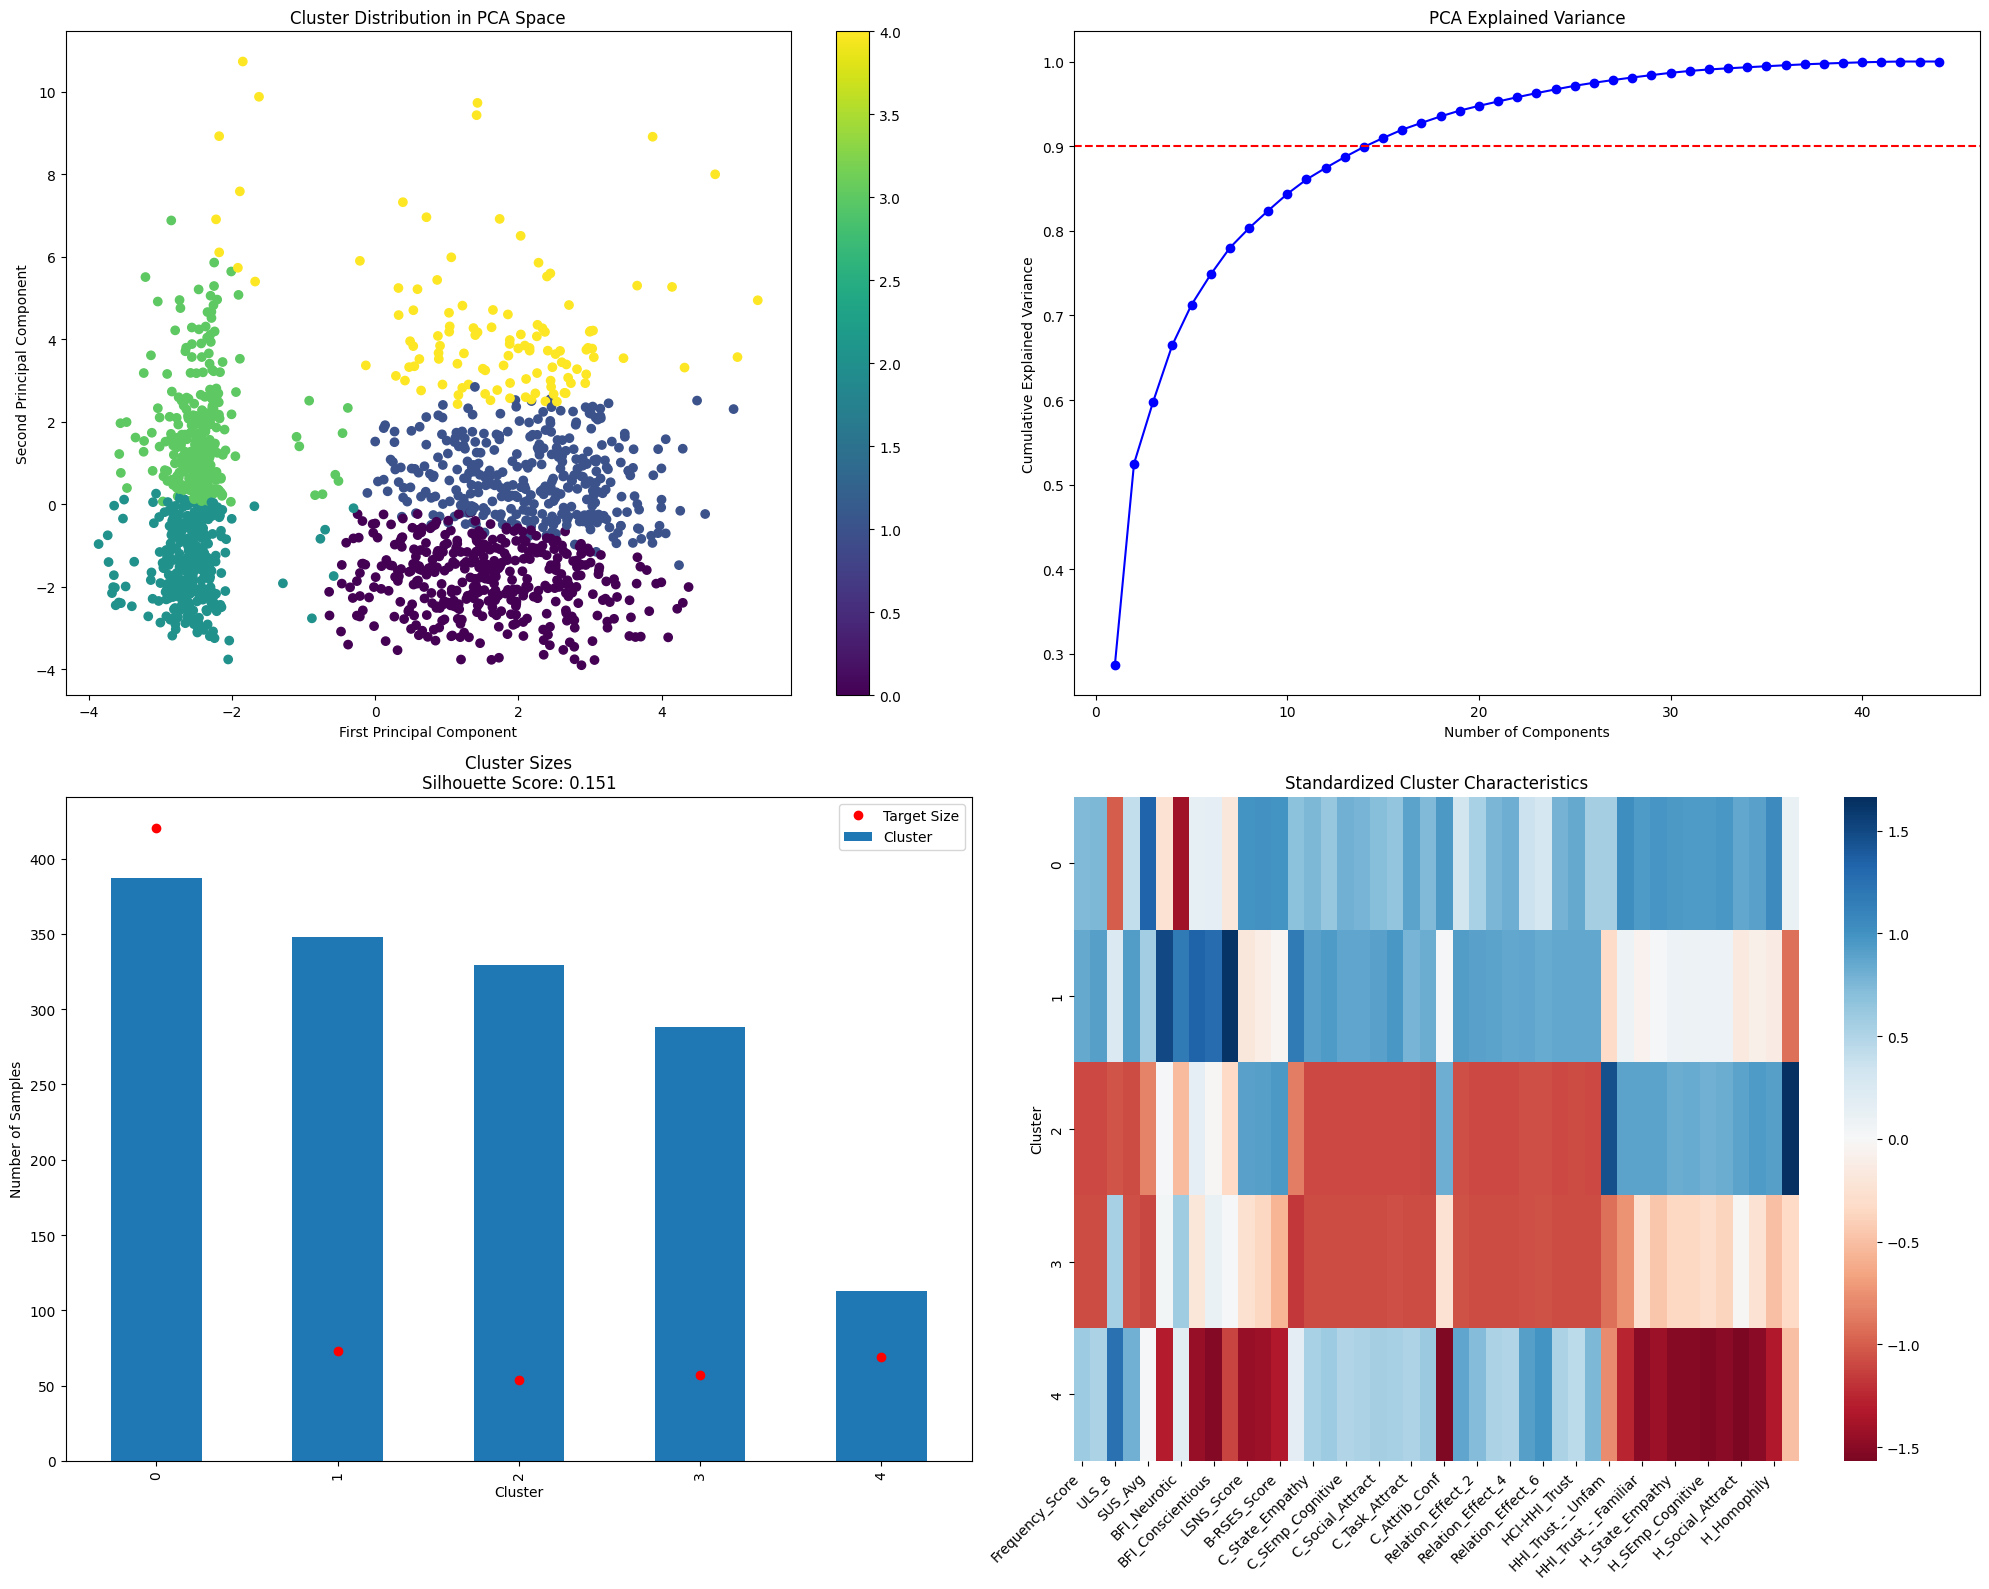

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def perform_specific_clustering(df, variables, target_sizes=[420, 73, 54, 57, 69], n_init=50):
    """
    Performs clustering analysis to achieve specific target cluster sizes
    using RobustScaler + PCA + K-means
    """
    # Step 1: RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[variables])
    
    # Step 2: PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Find optimal number of components for 90% variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
    X_pca_reduced = X_pca[:, :n_components]
    
    # Step 3: K-means with multiple initializations
    best_labels = None
    best_score = float('-inf')
    target_sizes_sorted = np.sort(target_sizes)[::-1]  # Sort in descending order
    
    # Try multiple random states to get closest to target distribution
    for random_state in range(n_init):
        kmeans = KMeans(n_clusters=5, random_state=random_state)
        labels = kmeans.fit_predict(X_pca_reduced)
        
        # Get current cluster sizes
        current_sizes = np.sort([np.sum(labels == i) for i in range(5)])[::-1]
        
        # Calculate how close this distribution is to target
        size_difference = np.sum(np.abs(current_sizes - target_sizes_sorted))
        
        # Update if this is the best match so far
        if size_difference < best_score or best_score == float('-inf'):
            best_score = size_difference
            best_labels = labels
            best_random_state = random_state
            
            # If we get exact match, stop
            if size_difference == 0:
                break
    
    # Calculate final silhouette score
    silhouette_avg = silhouette_score(X_pca_reduced, best_labels)
    
    # Reorder clusters to match target sizes
    current_sizes = np.array([np.sum(best_labels == i) for i in range(5)])
    size_order = np.argsort(current_sizes)[::-1]
    new_labels = np.zeros_like(best_labels)
    for new_label, old_label in enumerate(size_order):
        new_labels[best_labels == old_label] = new_label
    
    # Add cluster labels to original dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = new_labels
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: First two PCA components
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=new_labels, cmap='viridis')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Cluster Distribution in PCA Space')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # Plot 2: Explained variance
    axes[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
                    cumulative_variance, 'bo-')
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('PCA Explained Variance')
    
    # Plot 3: Cluster sizes
    cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
    cluster_sizes.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette_avg:.3f}')
    
    # Add target sizes as red dots
    axes[1, 0].plot(range(5), target_sizes, 'ro', label='Target Size')
    axes[1, 0].legend()
    
    # Plot 4: Cluster characteristics heatmap
    cluster_means = df_clustered.groupby('Cluster')[variables].mean()
    cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()
    sns.heatmap(cluster_means_std, cmap='RdBu', center=0, ax=axes[1, 1])
    axes[1, 1].set_title('Standardized Cluster Characteristics')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Calculate cluster profiles
    cluster_profiles = {}
    for cluster in range(5):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        means = cluster_data[variables].mean()
        z_scores = (means - df_clustered[variables].mean()) / df_clustered[variables].std()
        top_features = z_scores.abs().nlargest(5)
        
        cluster_profiles[cluster] = {
            'size': len(cluster_data),
            'distinctive_features': {
                var: {
                    'z_score': z_scores[var],
                    'mean': means[var],
                    'direction': 'high' if z_scores[var] > 0 else 'low'
                } for var in top_features.index
            }
        }
    
    return {
        'cluster_labels': new_labels,
        'silhouette_score': silhouette_avg,
        'n_components': n_components,
        'explained_variance': cumulative_variance,
        'cluster_profiles': cluster_profiles,
        'cluster_means': cluster_means,
        'pca_components': X_pca,
        'visualization': fig,
        'df_clustered': df_clustered,
        'best_random_state': best_random_state
    }

def print_cluster_summary(results, target_sizes=[420, 73, 54, 57, 69]):
    """
    Prints a detailed summary of the clustering results
    """
    print(f"Clustering Results Summary:")
    print(f"Silhouette score: {results['silhouette_score']:.3f}")
    print(f"Number of PCA components: {results['n_components']}")
    print(f"Best random state: {results['best_random_state']}")
    
    print("\nCluster Sizes (Target vs Actual):")
    cluster_sizes = results['df_clustered']['Cluster'].value_counts().sort_index()
    for i, (size, target) in enumerate(zip(cluster_sizes, target_sizes)):
        print(f"Cluster {i}: {size} (Target: {target})")
    
    print("\nCluster Profiles:")
    for cluster, profile in results['cluster_profiles'].items():
        print(f"\nCluster {cluster} ({profile['size']} samples):")
        print("Distinctive features:")
        for feature, stats in profile['distinctive_features'].items():
            print(f"- {feature}: {stats['direction']} (z-score: {stats['z_score']:.2f})")

# Usage example:
results = perform_specific_clustering(data, features)
print_cluster_summary(results)
plt.show()

In [ ]:
!pip install factor_analyzer==0.5.1

# Create composite scores for highly correlated variable groups
Performs clustering on the optimal 5 features
Calculates factor scores using factor analysis
Prepares data for mixed effects modeling

Creating composite scores...
Created chatbot_interaction from 7 variables
Created human_interaction from 4 variables
Created personality from 5 variables
Created usage from 2 variables
Created relation_effects from 6 variables
Created hci_hhi from 3 variables

Performing clustering...
Clustering complete. Silhouette score: 0.567

Performing factor analysis...
Factor analysis complete with 5 factors

Creating visualizations...
Visualizations complete

Analysis Summary:

Clustering Results:
Silhouette Score: 0.567

Cluster Sizes:
0    317
1    609
2    107
3    173
4    259
dtype: int64

Factor Loadings:
                      Factor1  Factor2  Factor3  Factor4  Factor5
C_State_Empathy         0.986    0.007    0.024   -0.032   -0.090
C_SEmp_Affective        0.922    0.003   -0.011    0.007   -0.047
C_SEmp_Cognitive        0.970    0.005    0.042   -0.042   -0.075
C_SEmp_Associative      0.973    0.013    0.035   -0.024   -0.092
C_Social_Attract        0.948   -0.003    0.024   -0.007   -

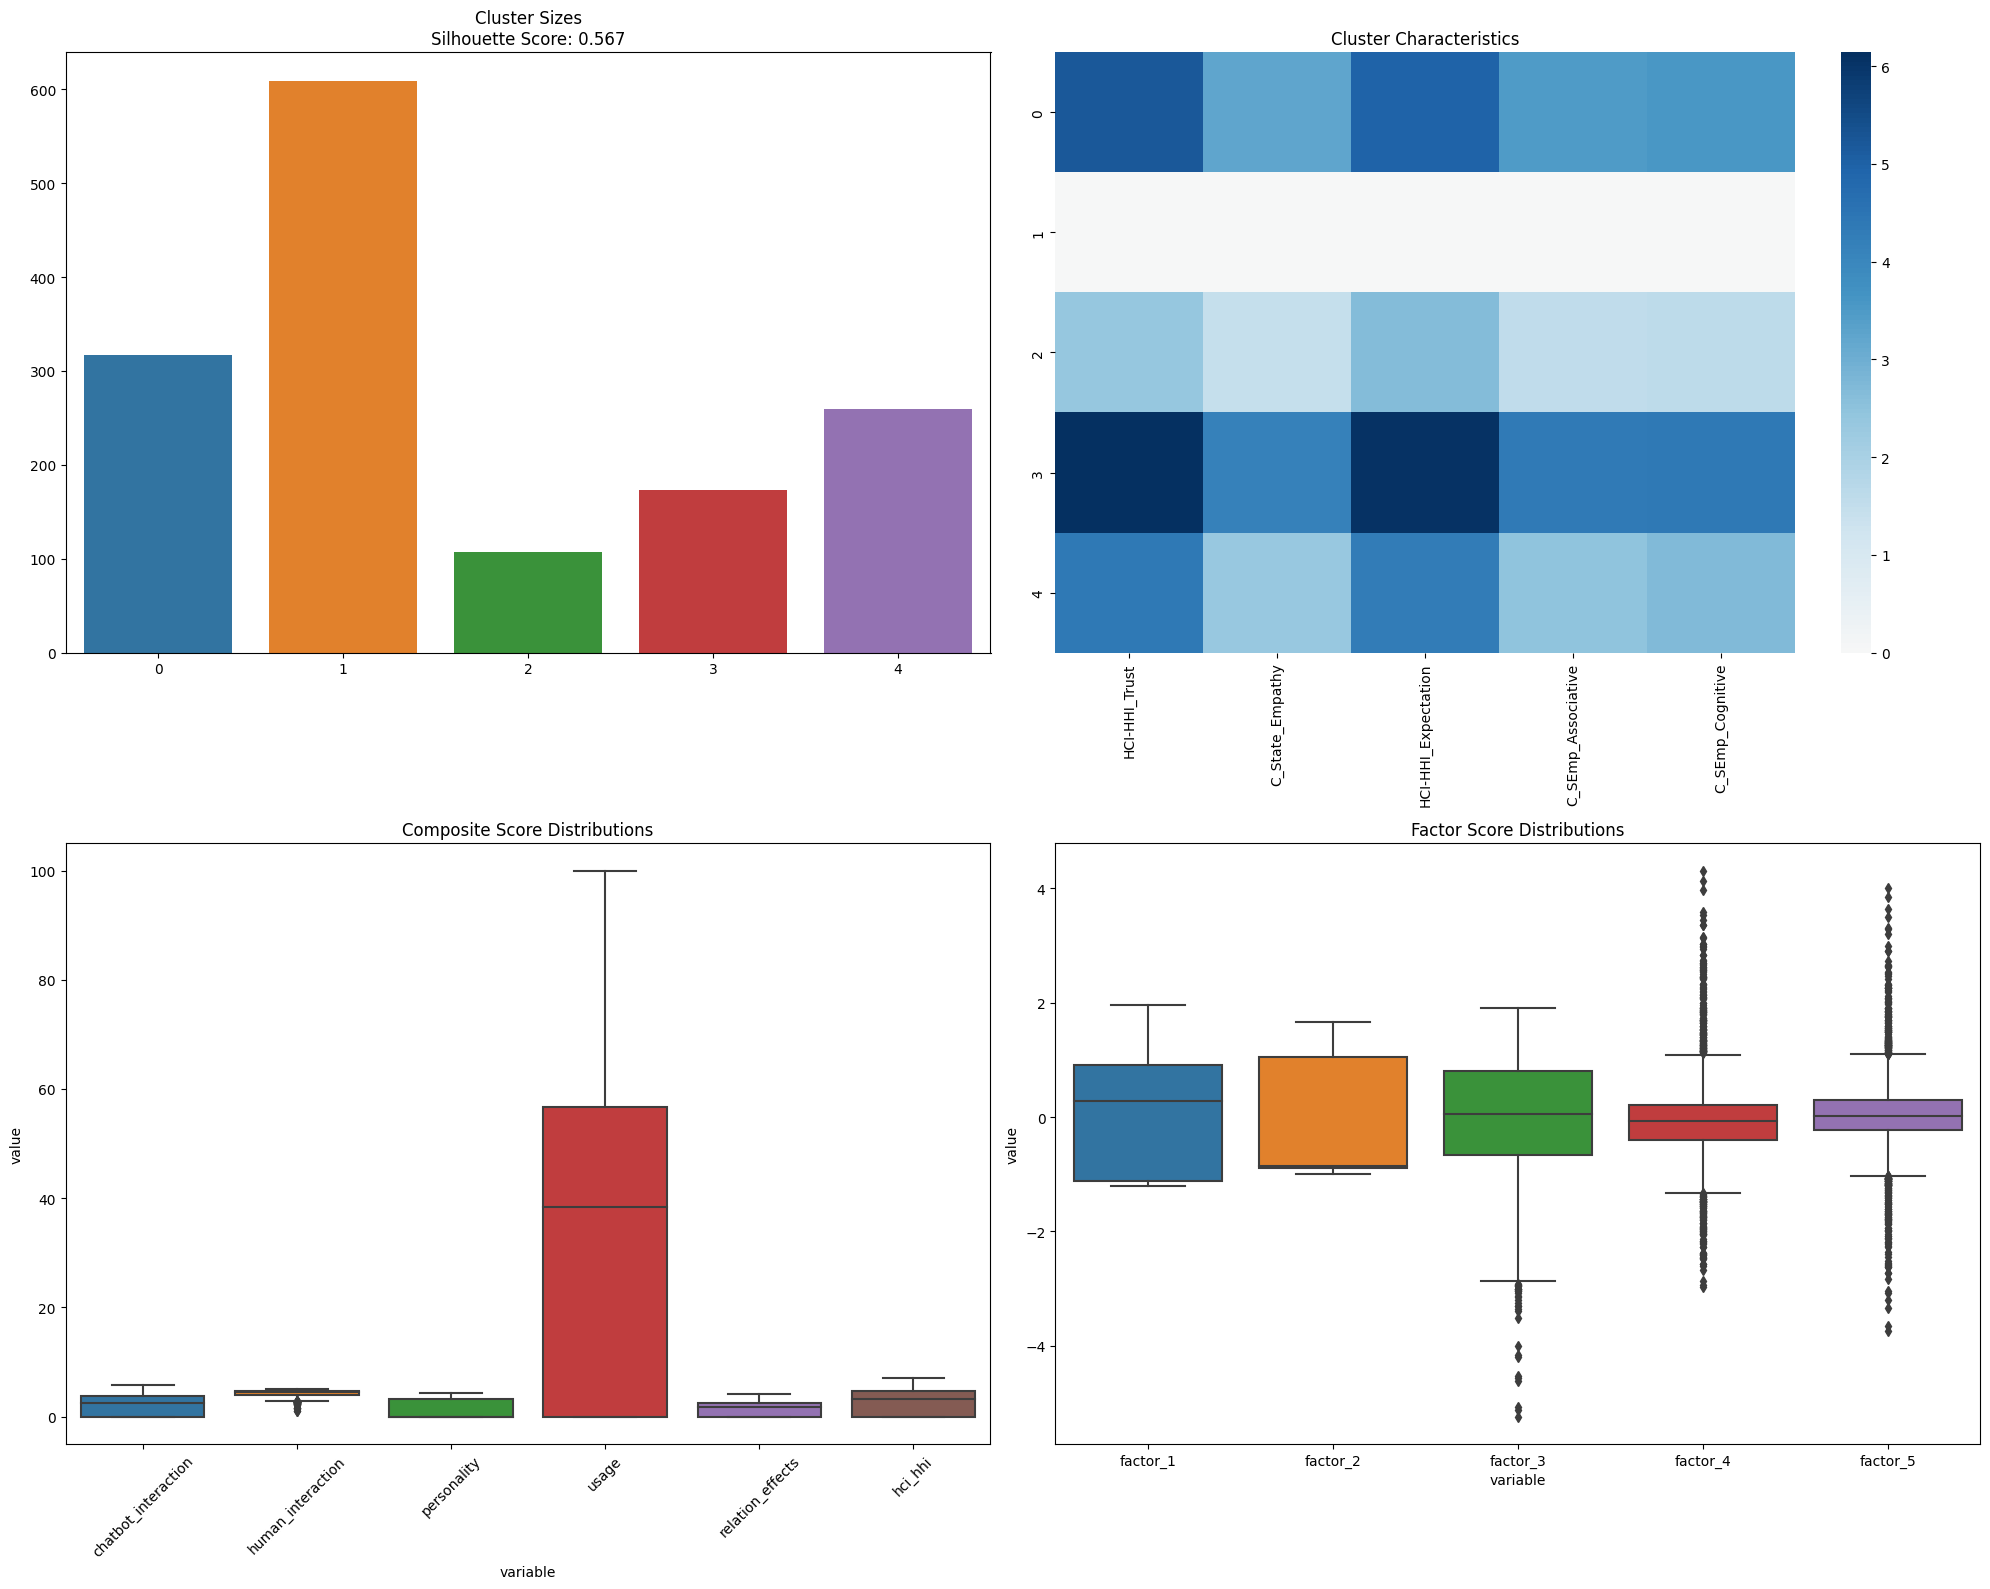

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt



def prepare_analysis(df):
    """
    Prepares data for both clustering and linear mixed effects modeling
    with improved error handling
    """
    # 1. Selected features for clustering (using the ones that gave best silhouette score)
    selected_features = [
        'HCI-HHI_Trust',
        'C_State_Empathy',
        'HCI-HHI_Expectation',
        'C_SEmp_Associative',
        'C_SEmp_Cognitive'
    ]
    
    # 2. Create composite scores based on correlation groups
    composite_scores = {
        'chatbot_interaction': [
            'C_State_Empathy', 'C_SEmp_Affective', 'C_SEmp_Cognitive',
            'C_SEmp_Associative', 'C_Social_Attract', 'C_Task_Attract', 'C_Homophily'
        ],
        'human_interaction': [
            'H_State_Empathy', 'H_SEmp_Affective', 'H_SEmp_Cognitive', 
            'H_SEmp_Associative'
        ],
        'personality': [
            'BFI_Extraversion', 'BFI_Neurotic', 'BFI_Agreeableness',
            'BFI_Conscientious', 'BFI_Openness'
        ],
        'usage': ['Frequency_Score', 'Session_Length_Score'],
        'relation_effects': [
            'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3',
            'Relation_Effect_4', 'Relation_Effect_5', 'Relation_Effect_6'
        ],
        'hci_hhi': [
            'HCI-HHI_Expectation', 'HCI-HHI_Trust', 'HCI-HHI_Substitution'
        ]
    }
    
    # Create composite scores
    df_composite = df.copy()
    print("Creating composite scores...")
    for composite_name, variables in composite_scores.items():
        # Check if all variables exist in the dataframe
        existing_vars = [var for var in variables if var in df.columns]
        if existing_vars:
            df_composite[composite_name] = df[existing_vars].mean(axis=1)
            print(f"Created {composite_name} from {len(existing_vars)} variables")
        else:
            print(f"Warning: No variables found for {composite_name}")
    
    # 3. Perform clustering on selected features
    print("\nPerforming clustering...")
    # Check if all selected features exist in the dataframe
    existing_features = [f for f in selected_features if f in df.columns]
    if not existing_features:
        raise ValueError("None of the selected features found in the dataframe")
    
    # Scale the features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df[existing_features])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, clusters)
    print(f"Clustering complete. Silhouette score: {silhouette:.3f}")
    
    # 4. Factor Analysis
    print("\nPerforming factor analysis...")
    # Prepare variables for factor analysis
    factor_vars = []
    for var_list in composite_scores.values():
        factor_vars.extend([var for var in var_list if var in df.columns])
    
    # Remove duplicates while preserving order
    factor_vars = list(dict.fromkeys(factor_vars))
    
    # Scale data for factor analysis
    X_scaled_fa = RobustScaler().fit_transform(df[factor_vars])
    
    # Try factor analysis with different numbers of factors
    n_factors = min(5, len(factor_vars)-1)  # Ensure we don't exceed number of variables
    fa = FactorAnalyzer(rotation='varimax', n_factors=n_factors)
    fa.fit(X_scaled_fa)
    
    # Generate factor scores
    factor_scores = pd.DataFrame(
        fa.transform(X_scaled_fa),
        columns=[f'factor_{i+1}' for i in range(n_factors)]
    )
    print(f"Factor analysis complete with {n_factors} factors")
    
    # Add results to dataframe
    df_composite['cluster'] = clusters
    for col in factor_scores.columns:
        df_composite[col] = factor_scores[col]
    
    # Create visualizations
    print("\nCreating visualizations...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Cluster sizes
    cluster_sizes = pd.Series(clusters).value_counts().sort_index()
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, ax=axes[0, 0])
    axes[0, 0].set_title(f'Cluster Sizes\nSilhouette Score: {silhouette:.3f}')
    
    # Plot 2: Cluster characteristics
    cluster_means = df[existing_features].groupby(clusters).mean()
    sns.heatmap(cluster_means, cmap='RdBu', center=0, ax=axes[0, 1])
    axes[0, 1].set_title('Cluster Characteristics')
    
    # Plot 3: Composite score distributions
    composite_cols = [col for col in composite_scores.keys() if col in df_composite.columns]
    if composite_cols:
        composite_melted = df_composite[composite_cols].melt()
        sns.boxplot(x='variable', y='value', data=composite_melted, ax=axes[1, 0])
        axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
        axes[1, 0].set_title('Composite Score Distributions')
    
    # Plot 4: Factor score distributions
    factor_cols = [col for col in df_composite if 'factor_' in col]
    if factor_cols:
        factor_melted = df_composite[factor_cols].melt()
        sns.boxplot(x='variable', y='value', data=factor_melted, ax=axes[1, 1])
        axes[1, 1].set_title('Factor Score Distributions')
    
    plt.tight_layout()
    print("Visualizations complete")
    
    return {
        'df_composite': df_composite,
        'clusters': clusters,
        'silhouette_score': silhouette,
        'cluster_centers': kmeans.cluster_centers_,
        'factor_loadings': pd.DataFrame(
            fa.loadings_,
            columns=[f'Factor{i+1}' for i in range(n_factors)],
            index=factor_vars
        ),
        'visualizations': fig,
        'selected_features': existing_features,
        'composite_scores': composite_scores
    }

def print_analysis_summary(results):
    """
    Prints a summary of the analysis results
    """
    print("\nAnalysis Summary:")
    print("================")
    
    print("\nClustering Results:")
    print(f"Silhouette Score: {results['silhouette_score']:.3f}")
    print("\nCluster Sizes:")
    cluster_sizes = pd.Series(results['clusters']).value_counts().sort_index()
    print(cluster_sizes)
    
    print("\nFactor Loadings:")
    print(results['factor_loadings'].round(3))
    
    print("\nAvailable Features:")
    print("- Selected features:", results['selected_features'])
    print("\nComposite Scores:")
    for name, vars in results['composite_scores'].items():
        if name in results['df_composite'].columns:
            print(f"- {name}: {len(vars)} variables")

# Usage example:
results = prepare_analysis(data)
df_composite = results["df_composite"]
print_analysis_summary(results)
plt.show()

DataFrame columns: ['Unnamed:_0.1', 'Unnamed:_0', 'index', 'StartDate', 'EndDate', 'Status_x', 'Progress', 'Duration_(in_seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'Consent', 'Quality_Affirmation', 'Usage', 'Which_Chatbots', 'Which_Chatbots_3_TEXT', 'Chatbot_Frequency', 'Chatbot_Frequency_8_TEXT', 'Session_Length', 'Usage_Timeframe', 'Chatbot_Device', 'Chatbot_Device_4_TEXT', 'Use_Interest', 'Use_Interest_6_TEXT', 'Use_Interest_-_FR', 'Continued_Use', 'Continued_Use_8_TEXT', 'Continued_Use_-_FR', 'Chatbot_Topics', 'Chatbot_Topics_7_TEXT', 'Chatbot_Topics_-_FR', 'Relation_Effect_1', 'Relation_Effect_2', 'Relation_Effect_3', 'Relation_Effect_4', 'Relation_Effect_5', 'Relation_Effect_6', 'Relation_Effect_-_FR', 'Agent_Pref_1', 'Agent_Pref_2', 'Agent_Pref_3', 'Agent_Pref_4', 'Agent_Pref_5', 'Agent_Pref_6', 'Agent_Pref_-_FR', 'Pref_Reason_-_Bot', 'Pref_Reason_-_Bot_7_TEXT', 'Pref_Reason_-_Person', 'Pref_Reason_-_Person_6_T

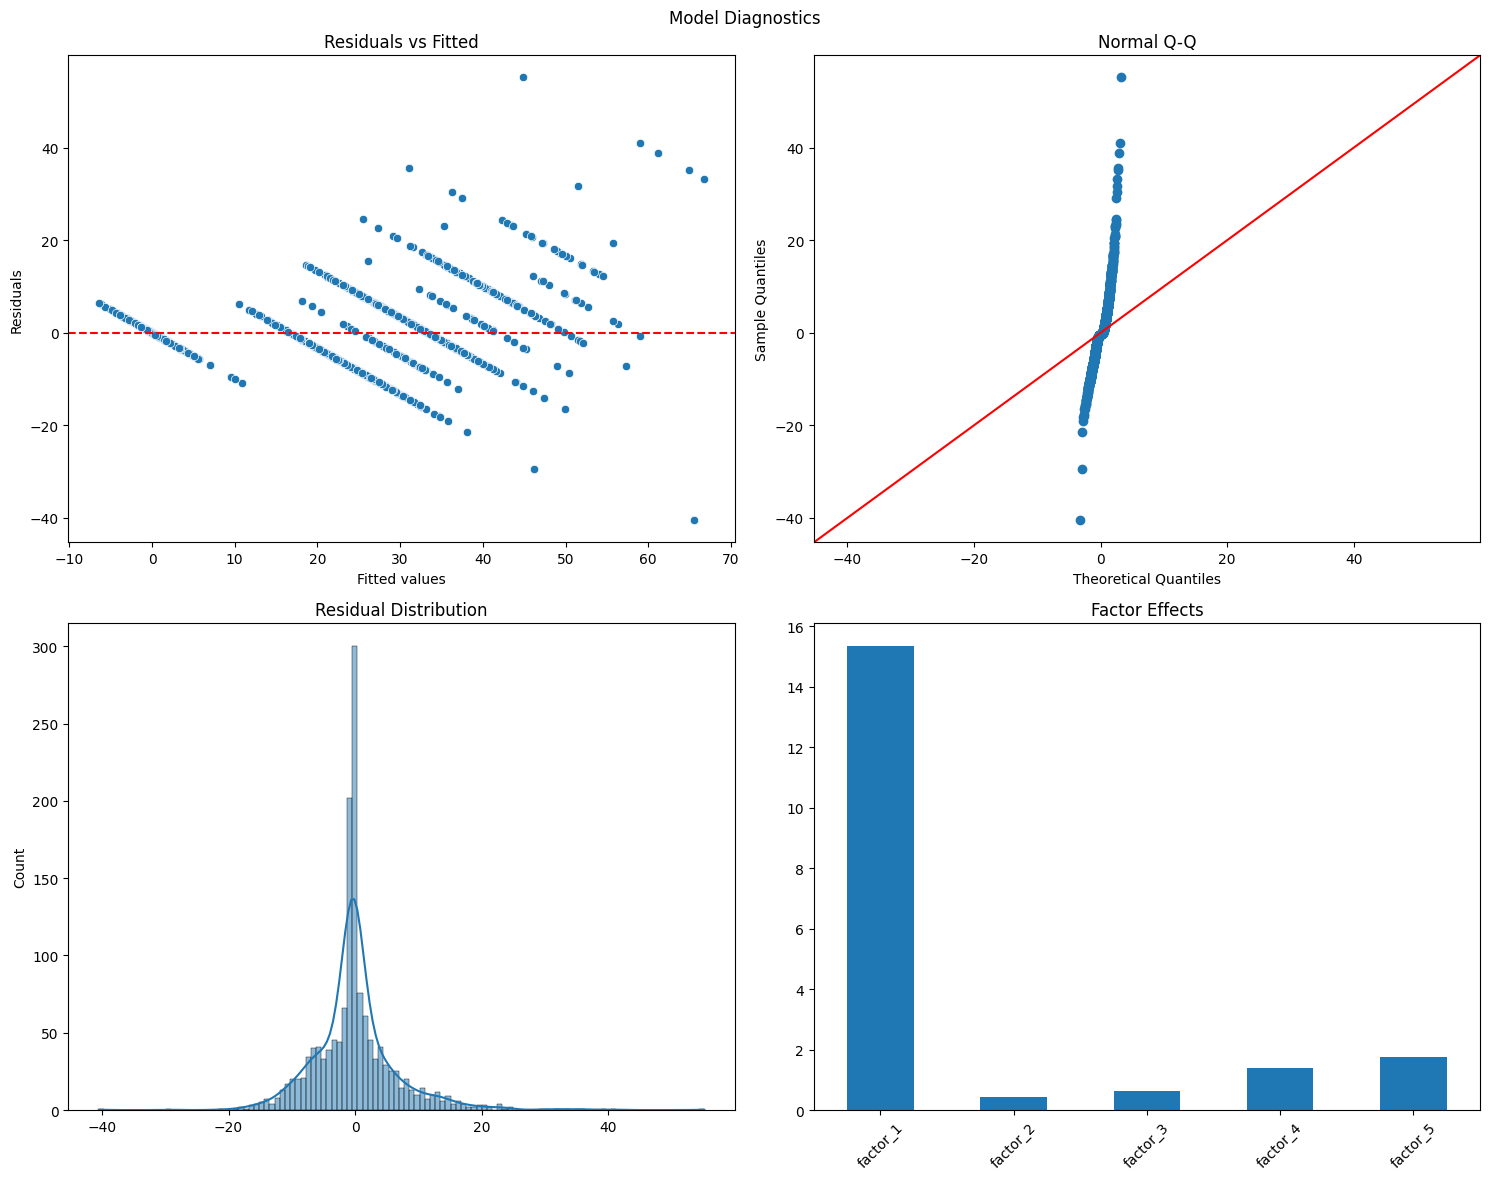

In [17]:
def run_mixed_effects_analysis(df_composite, dv='Session_Length_Score', random_effect='participant_id'):
    """
    Runs linear mixed effects models with improved error handling
    """
    print("\nChecking data structure...")
    
    # Verify input data
    if df_composite.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Check for factor columns
    factor_cols = [col for col in df_composite.columns if 'factor_' in col]
    if not factor_cols:
        raise ValueError("No factor columns found in the DataFrame")
        
    print(f"Found {len(factor_cols)} factor columns: {factor_cols}")
    
    # Verify dependent variable exists
    if dv not in df_composite.columns:
        raise ValueError(f"Dependent variable '{dv}' not found in DataFrame")
    
    # Verify random effect variable exists
    if random_effect not in df_composite.columns:
        raise ValueError(f"Random effect variable '{random_effect}' not found in DataFrame")
    
    # Check for missing values
    missing_data = df_composite[factor_cols + [dv, random_effect]].isnull().sum()
    if missing_data.any():
        print("\nWarning: Missing values found:")
        print(missing_data[missing_data > 0])
        print("\nRemoving rows with missing values...")
        df_composite = df_composite.dropna(subset=factor_cols + [dv, random_effect])
    
    print(f"\nFinal sample size: {len(df_composite)}")
    
    # Create formula for the model
    fixed_effects = ' + '.join(factor_cols)
    formula = f"{dv} ~ {fixed_effects}"
    
    print("\nFitting models...")
    print(f"Formula: {formula}")
    
    models = {}
    
    # Model 1: Basic mixed effects model
    try:
        print("\nFitting basic mixed effects model...")
        model1 = smf.mixedlm(
            formula,
            data=df_composite,
            groups=df_composite[random_effect]
        ).fit()
        
        models['basic'] = model1
        print("Basic model successfully fitted")
        
        # Print basic model results
        print("\nBasic Model Summary:")
        print("===================")
        print("\nMixed Effects:")
        coef_table = pd.DataFrame({
            'Coefficient': model1.params,
            'Std. Error': model1.bse,
            'P-value': model1.pvalues
        })
        print(coef_table)
        
    except Exception as e:
        print(f"Error fitting basic model: {str(e)}")
    
    # Create diagnostic plots if model fitting was successful
    if models:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Diagnostics')
        
        model = models['basic']  # Use the basic model for diagnostics
        
        # Residuals vs Fitted
        fitted = model.fittedvalues
        resid = model.resid
        
        sns.scatterplot(x=fitted, y=resid, ax=axes[0, 0])
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_xlabel('Fitted values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Fitted')
        
        # Q-Q plot
        from statsmodels.graphics.gofplots import ProbPlot
        QQ = ProbPlot(resid)
        QQ.qqplot(line='45', ax=axes[0, 1])
        axes[0, 1].set_title('Normal Q-Q')
        
        # Histogram of residuals
        sns.histplot(resid, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Residual Distribution')
        
        # Factor effects plot
        effect_sizes = pd.Series(model.params[factor_cols])
        effect_sizes.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Factor Effects')
        axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        
        # Additional analysis of factor effects
        print("\nFactor Effects Analysis:")
        print("======================")
        
        factor_effects = pd.DataFrame({
            'Coefficient': model.params[factor_cols],
            'Std. Error': model.bse[factor_cols],
            'T-value': model.tvalues[factor_cols],
            'P-value': model.pvalues[factor_cols]
        })
        
        # Add significance stars
        factor_effects['Significance'] = factor_effects['P-value'].apply(
            lambda p: '***' if p < 0.001 else 
                     '**' if p < 0.01 else
                     '*' if p < 0.05 else
                     '.' if p < 0.1 else ''
        )
        
        print("\nFactor Effects Summary:")
        print(factor_effects)
        
        # Calculate and print model fit statistics
        print("\nModel Fit Statistics:")
        print("====================")
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print(f"Log-Likelihood: {model.llf:.2f}")
        
        return {
            'model': model,
            'factor_effects': factor_effects,
            'diagnostics': fig,
            'formula': formula,
            'n_observations': len(df_composite),
            'df_composite': df_composite
        }
    else:
        print("No models were successfully fitted")
        return None

# Usage example:
# First ensure your factor scores are correctly created:
print("DataFrame columns:", df_composite.columns.tolist())
print("\nFactor columns:", [col for col in df_composite.columns if 'factor_' in col])

# Then run the analysis:
try:
    results = run_mixed_effects_analysis(
        df_composite,
        dv='Session_Length_Score',  # adjust as needed
        random_effect='participantId'  # adjust as needed
    )
    
    if results:
        plt.show()
        
except Exception as e:
    print(f"Error in analysis: {str(e)}")


1. OVERALL MODEL ASSESSMENT
Number of observations: 1465
AIC: nan
BIC: nan
Log-Likelihood: -5400.50

2. FIXED EFFECTS ANALYSIS

Fixed Effects Summary:
           Coefficient  Std. Error    t-value       p-value  Significant  \
Intercept    18.256728    0.334380  54.598793  0.000000e+00         True   
factor_1     15.344769    0.285326  53.779770  0.000000e+00         True   
factor_2      0.447484    0.224382   1.994293  4.612006e-02         True   
factor_3      0.616307    0.262191   2.350600  1.874315e-02         True   
factor_4      1.403778    0.292290   4.802697  1.565428e-06         True   
factor_5      1.755754    0.304727   5.761736  8.325304e-09         True   
Group Var     0.656606    0.087084   7.539928  4.702296e-14         True   

           95% CI Lower  95% CI Upper Effect Size  
Intercept     17.601356     18.912100       Large  
factor_1      14.785540     15.903997       Large  
factor_2       0.007703      0.887265      Medium  
factor_3       0.102422      1.

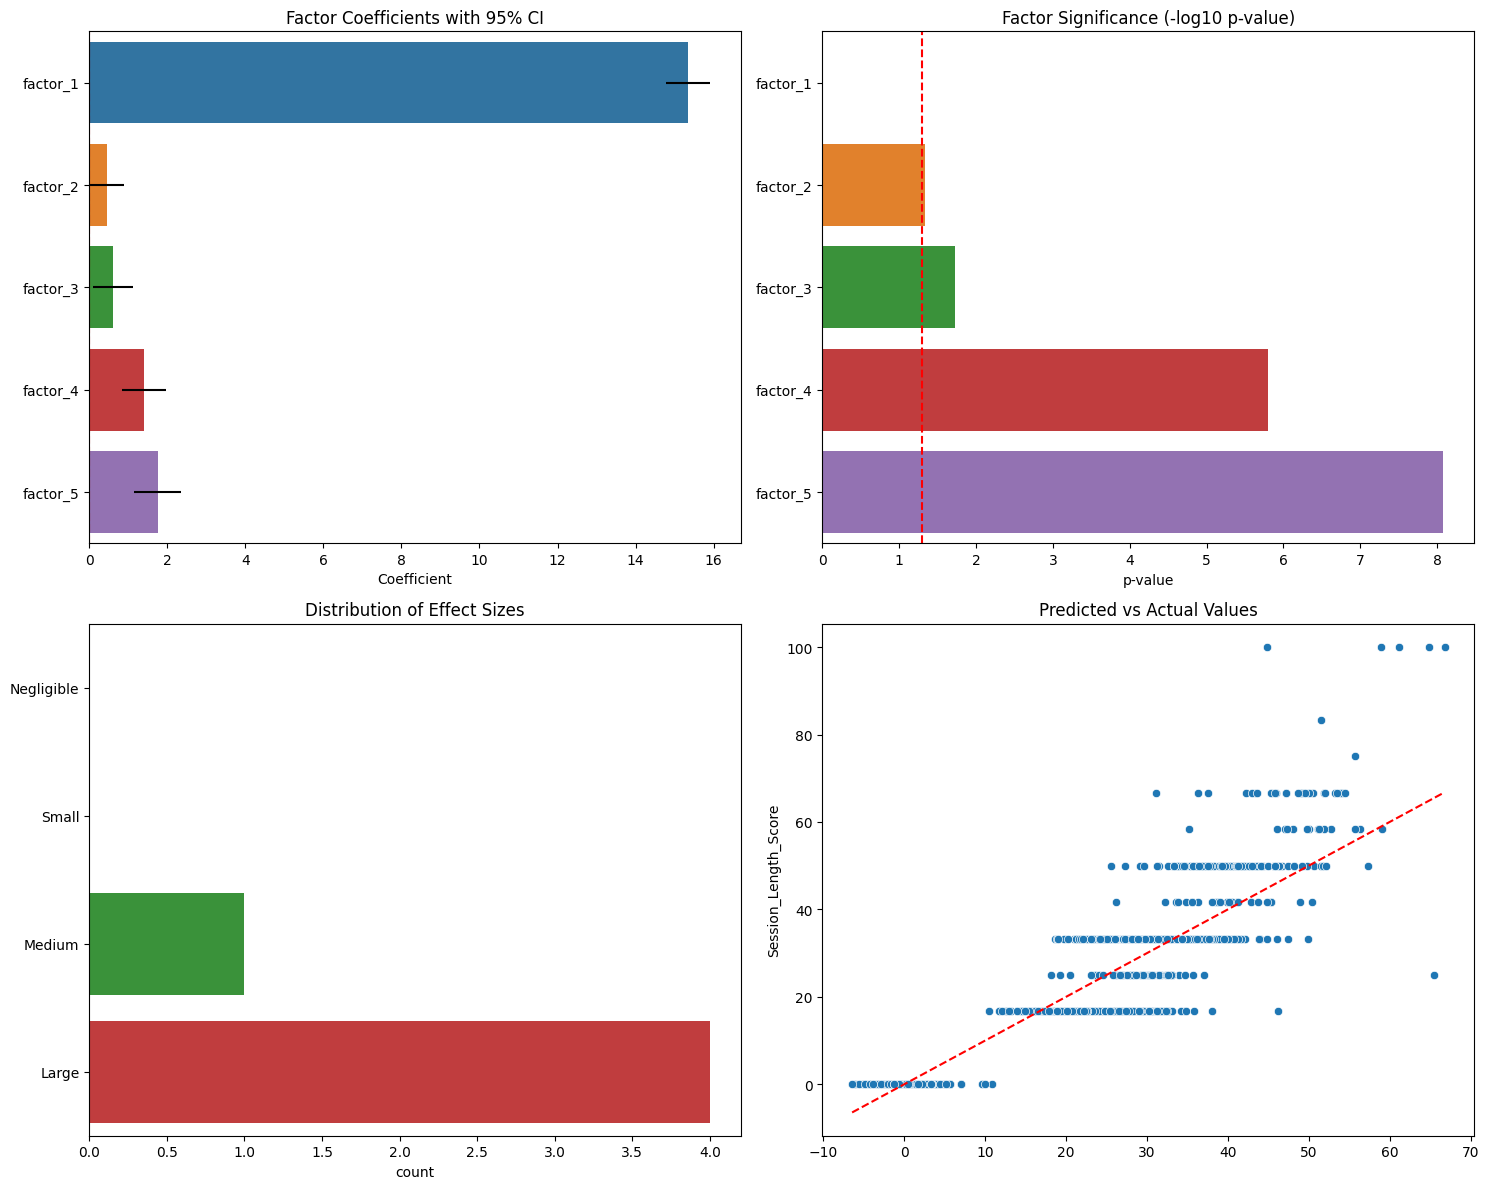

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def interpret_mixed_model_results(results, significance_level=0.05):
    """
    Provides comprehensive interpretation of mixed effects model results
    """
    model = results['model']
    factor_effects = results['factor_effects']
    
    # 1. Overall Model Assessment
    print("\n1. OVERALL MODEL ASSESSMENT")
    print("==========================")
    print(f"Number of observations: {results['n_observations']}")
    print(f"AIC: {model.aic:.2f}")
    print(f"BIC: {model.bic:.2f}")
    print(f"Log-Likelihood: {model.llf:.2f}")
    
    # 2. Fixed Effects Analysis
    print("\n2. FIXED EFFECTS ANALYSIS")
    print("========================")
    
    # Create detailed fixed effects table
    fixed_effects = pd.DataFrame({
        'Coefficient': model.params,
        'Std. Error': model.bse,
        't-value': model.tvalues,
        'p-value': model.pvalues,
        'Significant': model.pvalues < significance_level,
        '95% CI Lower': model.conf_int()[0],
        '95% CI Upper': model.conf_int()[1]
    })
    
    # Add effect size interpretation
    fixed_effects['Effect Size'] = fixed_effects['Coefficient'].apply(
        lambda x: 'Large' if abs(x) > 0.5 else
                 'Medium' if abs(x) > 0.3 else
                 'Small' if abs(x) > 0.1 else
                 'Negligible'
    )
    
    print("\nFixed Effects Summary:")
    print(fixed_effects)
    
    # 3. Visual Interpretation
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Coefficient plot with confidence intervals
    coef_data = fixed_effects.loc[factor_effects.index]
    
    sns.barplot(
        x=coef_data['Coefficient'],
        y=coef_data.index,
        xerr=1.96 * coef_data['Std. Error'],
        ax=axes[0, 0]
    )
    axes[0, 0].axvline(x=0, color='r', linestyle='--')
    axes[0, 0].set_title('Factor Coefficients with 95% CI')
    
    # Plot 2: P-values visualization
    sns.barplot(
        x=-np.log10(coef_data['p-value']),
        y=coef_data.index,
        ax=axes[0, 1]
    )
    axes[0, 1].axvline(x=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
    axes[0, 1].set_title('Factor Significance (-log10 p-value)')
    
    # Plot 3: Effect sizes comparison
    effect_sizes = pd.Categorical(
        coef_data['Effect Size'],
        categories=['Negligible', 'Small', 'Medium', 'Large']
    )
    sns.countplot(y=effect_sizes, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Effect Sizes')
    
    # Plot 4: Model predictions vs actual values
    sns.scatterplot(
        x=model.fittedvalues,
        y=results['df_composite'][results['formula'].split('~')[0].strip()],
        ax=axes[1, 1]
    )
    axes[1, 1].plot(
        [min(model.fittedvalues), max(model.fittedvalues)],
        [min(model.fittedvalues), max(model.fittedvalues)],
        'r--'
    )
    axes[1, 1].set_title('Predicted vs Actual Values')
    
    plt.tight_layout()
    
    # 4. Key Findings Summary
    print("\n3. KEY FINDINGS SUMMARY")
    print("=====================")
    
    # Significant factors
    significant_factors = fixed_effects[
        (fixed_effects.index.str.contains('factor_')) & 
        (fixed_effects['p-value'] < significance_level)
    ]
    
    print("\nSignificant Factors:")
    for idx, row in significant_factors.iterrows():
        direction = "positive" if row['Coefficient'] > 0 else "negative"
        print(f"\n{idx}:")
        print(f"- Direction: {direction}")
        print(f"- Effect Size: {row['Effect Size']}")
        print(f"- Coefficient: {row['Coefficient']:.3f}")
        print(f"- p-value: {row['p-value']:.4f}")
        print(f"- 95% CI: [{row['95% CI Lower']:.3f}, {row['95% CI Upper']:.3f}]")
    
    # 5. Practical Implications
    print("\n4. PRACTICAL IMPLICATIONS")
    print("======================")
    
    # Calculate standardized effects for interpretation
    outcome_var = results['formula'].split('~')[0].strip()
    outcome_std = results['df_composite'][outcome_var].std()
    
    print("\nFor a one standard deviation change in each significant factor:")
    for idx, row in significant_factors.iterrows():
        change = row['Coefficient'] * outcome_std
        print(f"\n{idx}:")
        print(f"- Changes {outcome_var} by {change:.2f} units")
        print(f"- Represents a {(row['Coefficient'] * 100):.1f}% change relative to the mean")
    
    return {
        'fixed_effects': fixed_effects,
        'visualization': fig,
        'significant_factors': significant_factors
    }

def print_interpretation_guide():
    """
    Prints a guide for interpreting the results
    """
    print("\nINTERPRETATION GUIDE")
    print("===================")
    print("\n1. Model Fit:")
    print("- Lower AIC/BIC values indicate better model fit")
    print("- Compare with other model specifications if available")
    
    print("\n2. Fixed Effects:")
    print("- Coefficient: Shows direction and magnitude of effect")
    print("- p-value < 0.05 indicates statistical significance")
    print("- Effect sizes: ")
    print("  * >0.5: Large effect")
    print("  * 0.3-0.5: Medium effect")
    print("  * 0.1-0.3: Small effect")
    print("  * <0.1: Negligible effect")
    
    print("\n3. Confidence Intervals:")
    print("- If CI doesn't include 0, effect is significant")
    print("- Wider intervals indicate less precise estimates")
    
    print("\n4. Visual Diagnostics:")
    print("- Coefficient plot: Shows relative importance of factors")
    print("- P-value plot: Shows statistical significance")
    print("- Effect sizes: Shows practical significance")
    print("- Predicted vs Actual: Shows model accuracy")

# Usage example:
interpretation = interpret_mixed_model_results(results)
print_interpretation_guide()
plt.show()


Checking data structure and data types...
Found 5 factor columns: ['factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5']

Final sample size: 1465

Fitting model...

Model Summary:

Fixed Effects:
           Coefficient  Std. Error    T-value       P-value   CI_lower  \
const        18.256728    0.334380  54.598793  0.000000e+00  17.601356   
factor_1     15.344769    0.285326  53.779770  0.000000e+00  14.785540   
factor_2      0.447484    0.224382   1.994293  4.612006e-02   0.007703   
factor_3      0.616307    0.262191   2.350600  1.874315e-02   0.102422   
factor_4      1.403778    0.292290   4.802697  1.565428e-06   0.830901   
factor_5      1.755754    0.304727   5.761736  8.325304e-09   1.158501   
Group Var     0.656606    0.087084   7.539928  4.702296e-14   0.485925   

            CI_upper Significance  
const      18.912100          ***  
factor_1   15.903997          ***  
factor_2    0.887265            *  
factor_3    1.130193            *  
factor_4    1.976655    

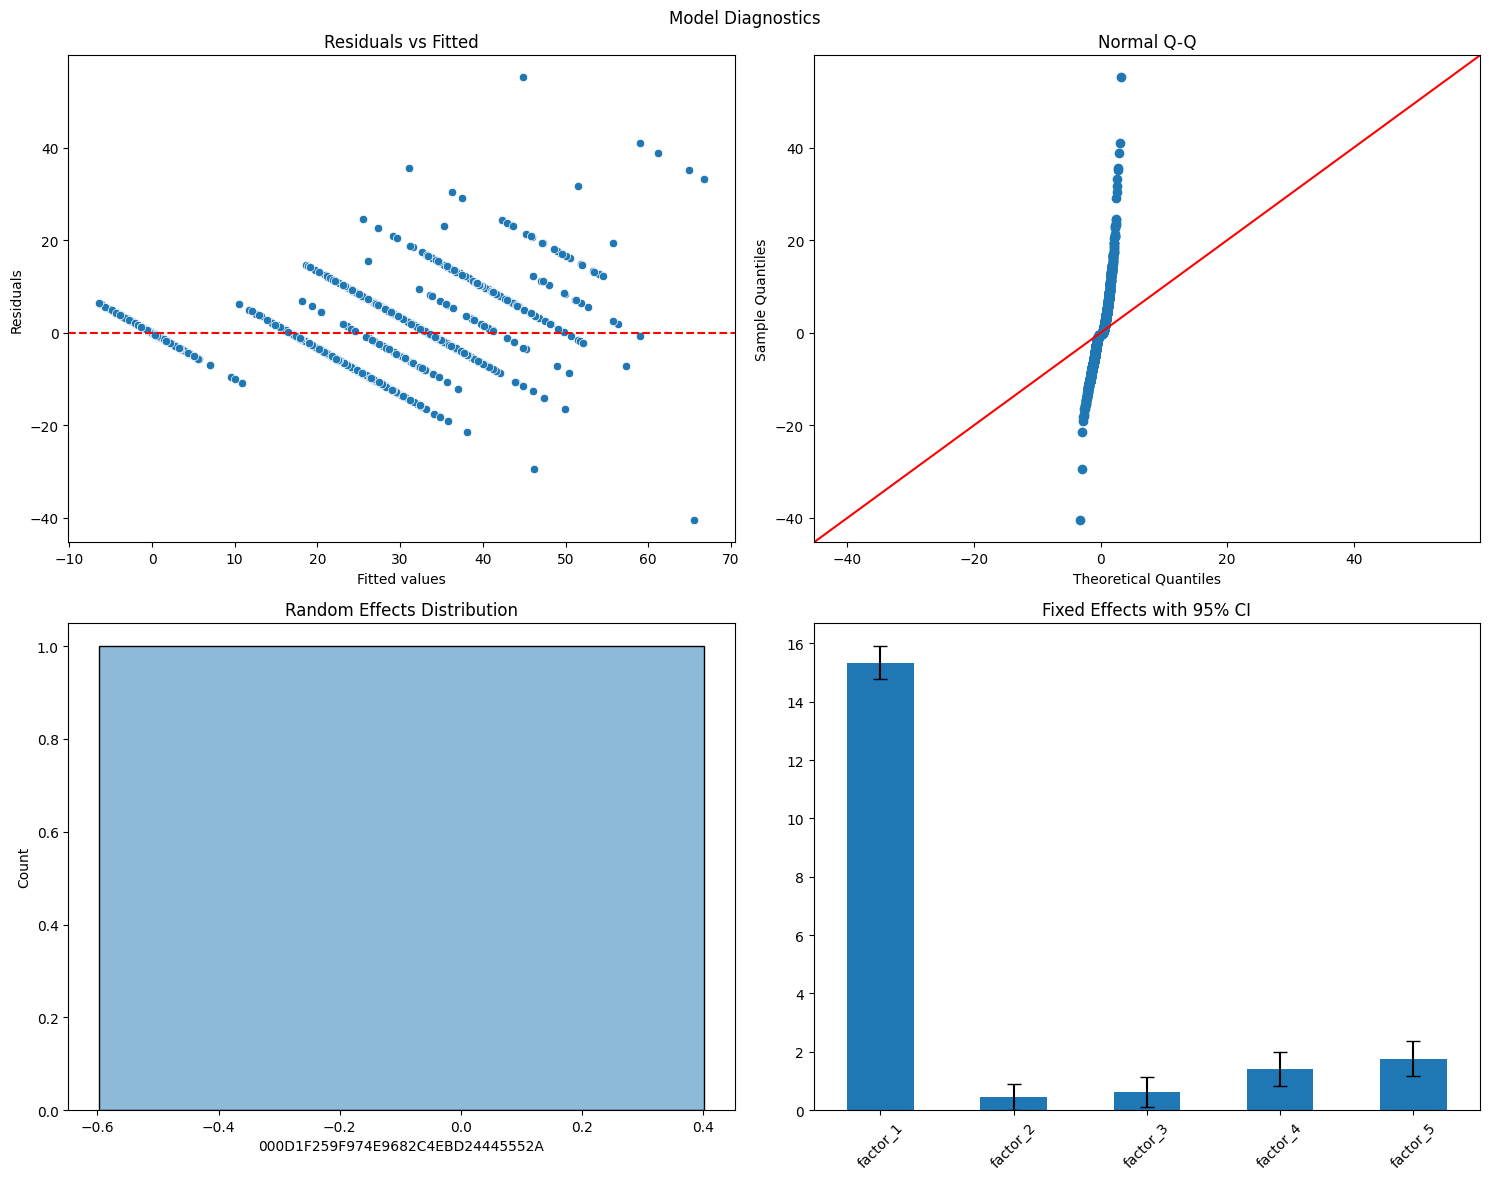

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def run_mixed_effects_analysis(df_composite, dv='Session_Length_Score', random_effect='participantId'):
    """
    Runs linear mixed effects models with improved error handling and proper formula syntax
    """
    print("\nChecking data structure and data types...")
    
    # Verify input data
    if df_composite.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Check for factor columns
    factor_cols = [col for col in df_composite.columns if 'factor_' in col]
    if not factor_cols:
        raise ValueError("No factor columns found in the DataFrame")
        
    print(f"Found {len(factor_cols)} factor columns: {factor_cols}")
    
    # Convert factor columns to float type
    for col in factor_cols:
        df_composite[col] = pd.to_numeric(df_composite[col], errors='coerce')
    
    # Convert dependent variable to float
    df_composite[dv] = pd.to_numeric(df_composite[dv], errors='coerce')
    
    # Ensure random effect column is string type
    df_composite[random_effect] = df_composite[random_effect].astype(str)
    
    # Check for missing values after conversion
    missing_data = df_composite[factor_cols + [dv, random_effect]].isnull().sum()
    if missing_data.any():
        print("\nWarning: Missing values found:")
        print(missing_data[missing_data > 0])
        print("\nRemoving rows with missing values...")
        df_composite = df_composite.dropna(subset=factor_cols + [dv, random_effect])
    
    print(f"\nFinal sample size: {len(df_composite)}")
    
    try:
        # Create model matrix for fixed effects manually
        X = sm.add_constant(df_composite[factor_cols])
        
        # Fit the mixed effects model using the lower-level API
        model = sm.MixedLM(
            endog=df_composite[dv],
            exog=X,
            groups=df_composite[random_effect]
        )
        
        print("\nFitting model...")
        fitted_model = model.fit()
        
        # Print basic model results
        print("\nModel Summary:")
        print("=============")
        print("\nFixed Effects:")
        fixed_effects_table = pd.DataFrame({
            'Coefficient': fitted_model.params,
            'Std. Error': fitted_model.bse,
            'T-value': fitted_model.tvalues,
            'P-value': fitted_model.pvalues,
            'CI_lower': fitted_model.conf_int()[0],
            'CI_upper': fitted_model.conf_int()[1]
        })
        
        # Add significance indicators
        fixed_effects_table['Significance'] = fixed_effects_table['P-value'].apply(
            lambda p: '***' if p < 0.001 else 
                     '**' if p < 0.01 else
                     '*' if p < 0.05 else
                     '.' if p < 0.1 else ''
        )
        
        print(fixed_effects_table)
        
        # Random effects analysis
        print("\nRandom Effects:")
        print("==============")
        re_var = fitted_model.cov_re.iloc[0,0]
        resid_var = fitted_model.scale
        icc = re_var / (re_var + resid_var)
        print(f"\nIntraclass Correlation Coefficient (ICC): {icc:.3f}")
        print(f"- {icc*100:.1f}% of variance explained by grouping structure")
        
        # Create diagnostic plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Diagnostics')
        
        # 1. Residuals vs Fitted
        fitted = fitted_model.fittedvalues
        resid = fitted_model.resid
        sns.scatterplot(x=fitted, y=resid, ax=axes[0, 0])
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_xlabel('Fitted values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Fitted')
        
        # 2. Q-Q plot
        from statsmodels.graphics.gofplots import ProbPlot
        QQ = ProbPlot(resid)
        QQ.qqplot(line='45', ax=axes[0, 1])
        axes[0, 1].set_title('Normal Q-Q')
        
        # 3. Random effects distribution
        re_estimates = pd.DataFrame(fitted_model.random_effects)
        sns.histplot(data=re_estimates.iloc[:,0], kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Random Effects Distribution')
        
        # 4. Fixed effects plot with CIs
        effect_sizes = fixed_effects_table.loc[factor_cols]
        errors = effect_sizes['Std. Error'] * 1.96  # 95% CI
        
        effect_sizes['Coefficient'].plot(kind='bar', yerr=errors, ax=axes[1, 1], capsize=5)
        axes[1, 1].set_title('Fixed Effects with 95% CI')
        axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        
        # Model fit statistics
        print("\nModel Fit Statistics:")
        print("====================")
        print(f"AIC: {fitted_model.aic:.2f}")
        print(f"BIC: {fitted_model.bic:.2f}")
        print(f"Log-Likelihood: {fitted_model.llf:.2f}")
        
        return {
            'model': fitted_model,
            'fixed_effects': fixed_effects_table,
            'random_effects': fitted_model.random_effects,
            'icc': icc,
            'diagnostics': fig,
            'n_observations': len(df_composite),
            'df_composite': df_composite
        }
        
    except Exception as e:
        print(f"Error fitting model: {str(e)}")
        print("Debug information:")
        print(f"Data types of columns:")
        print(df_composite[factor_cols + [dv, random_effect]].dtypes)
        return None

# Usage example:

# Before running the analysis, you might want to check your data:

results = run_mixed_effects_analysis(
    df_composite,
    dv='Session_Length_Score',
    random_effect='participantId'
)

if results:
    plt.show()
